# Constants and Setup

In [1]:
import os

# whether to commit and push to git after each optimization. intended for long runs
PUSH_TO_GIT = True

# parent output directory
EXPERIMENTS_DIR = os.path.join("experiments", "bayes_opt_2")

Bayesian Optimization and train parameters

In [2]:
MAX_ITERATIONS = 10     # max iterations for bayesian optimization

NUM_TRAIN_EPOCHS = 50   # total number of epochs tot rain for
EARLY_STOP = 6          # give up training if validation accuracy doesn't improve after this many epochs

Optimizer to use. Choose by commenting. Supposedly by Wilson et al. 2018, SGD generalizes better.

In [3]:
import torch.optim as optim

OPTIMIZERS = (
    optim.Adam,
    optim.SGD,
)

Models to test for BO. All in the list will be optimized.

In [4]:
from torchvision import models as tvm
import pretrainedmodels as ptm

# The models we will test
MODELS = (
#     ptm.alexnet, # gets maximum recursion limit exceeded exceptions
#     se_resnext101_32x4d, # input size doesn't work
    ptm.nasnetamobile,
    ptm.se_resnet50,
    ptm.se_resnet101,
    ptm.inceptionresnetv2,
    ptm.inceptionv4,
    tvm.resnet101,
    tvm.resnet152,
    ptm.senet154,
    ptm.pnasnet5large,  # CUDA out of memory errors. only works batch_size <= 12
    ptm.polynet,  # CUDA out of memory. only works batch_size <= 16
    ptm.nasnetalarge, # only works batch_size <= 12
    ptm.vgg16,
    ptm.vgg19,
)

REQUIRES_SMALL_BATCH = {ptm.pnasnet5large, ptm.polynet, ptm.nasnetalarge}

Setup: Make sure Jupyter shows all output

In [5]:
# show more than one output in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# display full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# plot charts in our notebook
%matplotlib inline

import subprocess  # for command line control, git
import sys
sys.setrecursionlimit(3000) # for some reason AlexNet requires more recursive depth

## Helper Functions

In [6]:
import src.utils as utils
from src.trainable import Trainable
import torch


CRITERION = torch.nn.CrossEntropyLoss() # we'll always use CE for the loss function
 

def train(params, is_best=False):
    """
    Set up a trainable and train it using the given parameters.
    """
    global iteration
    iteration += 1
    print('Iteration', iteration if not is_best else "BEST", end=', ')
    print(params_to_meta_dict(params))  # print the input
    batch_size, lr_factor, optim_params = parse_train_params(params)
    
    # make an output directory using the dataset name, model name, and BO iteration
    outdir = make_outdir_name(
        data_dir, 
        utils.get_model_name(chosen_model), 
        chosen_optimizer.__name__,
        str(iteration) if not is_best else "BEST",
        prepend=EXPERIMENTS_DIR
    )
    
    # make our data loaders based on the image size
    image_size = utils.determine_image_size(utils.get_model_name(chosen_model))
    # get_train_val_dataloaders() makes a stratified random partitions of a train and validation set
    dataloaders = utils.get_train_val_dataloaders(
        datadir=data_dir,
        val_proportion=0.15,
        image_size=image_size, 
        batch_size=batch_size
    )
    # build our model
    model = build_model(chosen_model)
    utils.fit_model_last_to_dataset(model, dataloaders['train'].dataset)
    # build the optimizer
    optimizer = chosen_optimizer(model.parameters(), *optim_params)
    # "ReduceOnPlateau" is "dev-decay" as recommended by Wilson et al. 2018 
    # "The Marginal Value of Adaptive Gradient Methods"
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=lr_factor, 
        patience=1
    )
    
    trainable = Trainable(dataloaders, model, CRITERION, optimizer, lr_scheduler, outdir=outdir)
    early_stop = None if is_best else EARLY_STOP  # only early stop if BO. else if training our best, do the full thing
    trainable.train(num_epochs=NUM_TRAIN_EPOCHS, early_stop_limit=early_stop, verbose=False)

    return trainable


def parse_train_params(params):
    """
    Parses train parameters by converting batch size to an int, and the betas to a tuple for Adam.
    """
    batch_size, lr_factor, optim_params = int(params[0]), params[1], params[2:]
    if chosen_optimizer is torch.optim.Adam:  # turn b1 and b2 into a tuple
        # NOTE the below indexes are based on purely ADAM_DOMAin
        optim_params = (optim_params[0], tuple(optim_params[1:3]), optim_params[3])
#         print('OPTIM_PARAMS', optim_params)
    return batch_size, lr_factor, optim_params

    
def build_model(model_fn):
    """
    Build a pretrained model class from a model function. Passes 
    in the appropriate pretrained arg based on the model function's 
    parent module.
    """
    if 'pretrainedmodels' in model_fn.__module__:
        model = model_fn(num_classes=1000, pretrained='imagenet')
    else:
        model = model_fn(pretrained=True)
    return model


def make_key_from_params(params):
    """
    Makes a unique key (as a tuple) from a given list of parameters.
    For storing associated Trainable objects.
    
    """
    return tuple(round(param, 10) for param in params)


def make_outdir_name(data_dir, *append, prepend=""):
    """
    Make the output directory name based on dataset, model name, and any extra info.
    """
    dataset_name = os.path.basename(data_dir)
    return os.path.join(prepend, dataset_name, *append) 


In [7]:
from IPython.display import Javascript

script = '''
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
'''
def save_notebook():
    """Save the Jupyter notebook"""
    Javascript(script)

def push_to_git(message="Commit"):
    save_notebook()
    try:
        _ = subprocess.check_call(['git', 'add', '-u'])
        _ = subprocess.check_call(['git', 'add', EXPERIMENTS_DIR])
        _ = subprocess.check_call(['git', 'commit', '-am', message])
        _ = subprocess.check_call(['git', 'push'])
    except Error as e:
        print("ERROR: Could not push to git.", e)

# Bayesian Optimization

## Define the Problem

### Domain

In [8]:
SMALL_BATCH = (1, 4, 8, 12)
MEDIUM_BATCH = (16, 24, 32, 48, 64)

BASE_DOMAIN = [
#     {'name': 'batch_size', 'type': 'discrete', 'domain': (1, 4, 8, 12)},  # DEBUG for GPUs with insufficient memory
    {'name': 'batch_size', 'type': 'discrete', 'domain': MEDIUM_BATCH},
    {'name': 'lr_decay', 'type': 'continuous', 'domain': (0.03, 0.3)},
]

ADAM_DOMAIN = BASE_DOMAIN + [
    {'name': 'adam_lr', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'adam_beta1', 'type': 'continuous', 'domain': (0.8, .99)},
    {'name': 'adam_beta2', 'type': 'continuous', 'domain': (0.95, .9999)},
    {'name': 'adam_wtdecay', 'type': 'continuous', 'domain': (0, 1)}
]
# TODO: have to figure out how to set a starting default
# default_input = [32, 0.001, 0.9, 0.999, 0] 

SGD_DOMAIN = BASE_DOMAIN + [
    {'name': 'lr', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'momentum', 'type': 'continuous', 'domain': (0.5, .99)},
    {'name': 'weight_decay', 'type': 'continuous', 'domain': (0, 1)}
]

### Function to optimize

In [9]:
def f(x):
    """ Value function to maximize for bayesian optimization """
    params = x.flatten()
#     print('PARAMS', params)
    
    trainable = train(params)
    val_acc = trainable.best_val_accuracy
    
    return val_acc

## Do BO on all models on both datasets.

In [10]:
from GPyOpt.methods import BayesianOptimization
from predict import create_predictions
from metrics import create_all_metrics

### BO helper functions

In [11]:
def reset_globals(datadir):
    """
    Reset the iteration and set the data directory
    """
    global iteration  # keep track of our optimization iterations for directory output
    iteration = 0   # but reset to 0 each train run
    global data_dir
    data_dir = datadir
    

def get_domain():
    """
    Get the domain parameters given the chosen optimizer
    """
    domain = ADAM_DOMAIN if chosen_optimizer is torch.optim.Adam else SGD_DOMAIN
    # some models are too big to fit on our NVIDIA Quadro P5000 GPU. if the
    # chosen model is on eof these, decrease the batch size
    if chosen_model in REQUIRES_SMALL_BATCH:
        domain[0]['domain'] = SMALL_BATCH  # domain[0] is batch_size
        
    return domain
    
def perform_bayesian_optimization():
    """
    Construct the problem and run the optimization.
    """
    domain = get_domain()
    problem = BayesianOptimization(
        f=f,
        domain=domain,
        maximize=True
    )
    problem.run_optimization(max_iter=MAX_ITERATIONS)
    return problem

def plot_bo_results(problem):
    """
    Graph the acquisition function and convergence
    """
    print('Best params:', problem.x_opt)
    problem.plot_acquisition()
    problem.plot_convergence()
    
    
def params_to_meta_dict(params):
    """
    Takes a list and returns a dictionary of named parameters based on domain index
    """
    domain = get_domain()
    meta = { d['name']: float(params[i]) for i, d in enumerate(domain)}
    return meta


def generate_test_metrics(trainable):
    """
    Create an itemized predictions file and metrics for the test set.
    """
    predictions_file = create_predictions(
        outdir=trainable.outdir,
        subset='test',
        data_dir=data_dir,
        model=best_trainable.model
    )
    create_all_metrics(predictions_file, trainable.outdir, 'test')

### Main loop

nasnetamobile Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.13606525397353542, 'adam_lr': 0.06531645144718246, 'adam_beta1': 0.8247192391926832, 'adam_beta2': 0.9700064907438666, 'adam_wtdecay': 0.8645788394673907}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9126
Iteration 2, {'batch_size': 16.0, 'lr_decay': 0.11741362142150999, 'adam_lr': 0.00521236652670609, 'adam_beta1': 0.8299715586062101, 'adam_beta2': 0.9995055749425191, 'adam_wtdecay': 0.18602089332358263}


Training stopped early at 21 epochs.
Best validation accuracy: 0.8222; Associated train accuracy: 0.9145
Iteration 3, {'batch_size': 16.0, 'lr_decay': 0.270681415967258, 'adam_lr': 0.06732472645562533, 'adam_beta1': 0.9474761502552853, 'adam_beta2': 0.9938210617577792, 'adam_wtdecay': 0.04335047879108145}


Training stopped early at 8 epochs.
Best validation accuracy: 0.5722; Associated train accuracy: 0.5501
Iteration 4, {'batch_size': 32.0, 'lr_decay': 0.052713297141560825, 'adam_lr': 0.08480504155927175, 'adam_beta1': 0.8932094423950917, 'adam_beta2': 0.9998927908209623, 'adam_wtdecay': 0.9416322057281397}


Training stopped early at 22 epochs.
Best validation accuracy: 0.8667; Associated train accuracy: 0.9106
Iteration 5, {'batch_size': 16.0, 'lr_decay': 0.04012164538015247, 'adam_lr': 0.08546931480059347, 'adam_beta1': 0.9104800666654932, 'adam_beta2': 0.976898118068372, 'adam_wtdecay': 0.5724790895195455}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.8713
Iteration 6, {'batch_size': 48.0, 'lr_decay': 0.14040122590326942, 'adam_lr': 0.05960909542557366, 'adam_beta1': 0.8132875439325197, 'adam_beta2': 0.9702166691443174, 'adam_wtdecay': 0.8619438838107064}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.8664
Iteration 7, {'batch_size': 48.0, 'lr_decay': 0.08171776884782313, 'adam_lr': 0.0691905368898733, 'adam_beta1': 0.836053328070918, 'adam_beta2': 0.9661867109001778, 'adam_wtdecay': 0.6814055239042898}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9204
Iteration 8, {'batch_size': 48.0, 'lr_decay': 0.2869770462256526, 'adam_lr': 0.015673634809715554, 'adam_beta1': 0.9307955348815274, 'adam_beta2': 0.9787357960964644, 'adam_wtdecay': 0.7250539502451895}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.9224
Iteration 9, {'batch_size': 48.0, 'lr_decay': 0.22431914137355102, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.4109315606288394}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9037
Iteration 10, {'batch_size': 48.0, 'lr_decay': 0.032128306440695906, 'adam_lr': 0.1, 'adam_beta1': 0.9788055705415829, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.3400202090181088}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9244
Iteration 11, {'batch_size': 48.0, 'lr_decay': 0.19577720990440586, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.12418383119757687}


Training stopped early at 17 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9077
Iteration 12, {'batch_size': 48.0, 'lr_decay': 0.3, 'adam_lr': 0.001, 'adam_beta1': 0.99, 'adam_beta2': 0.95, 'adam_wtdecay': 0.36571864704234663}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7833; Associated train accuracy: 0.8271
Iteration 13, {'batch_size': 48.0, 'lr_decay': 0.03, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.3966377054320075}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9136
Iteration 14, {'batch_size': 16.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.9214615520190845}


Training stopped early at 22 epochs.
Best validation accuracy: 0.6167; Associated train accuracy: 0.7043
Iteration 15, {'batch_size': 16.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.388589286408351}


Training stopped early at 14 epochs.
Best validation accuracy: 0.8389; Associated train accuracy: 0.8861
Best params: [48.          0.22431914  0.1         0.8         0.9999      0.41093156]


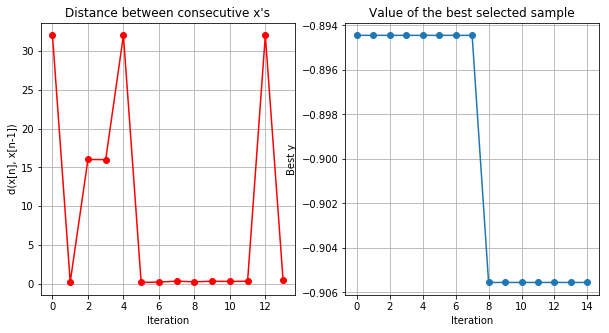

Best params: {'batch_size': 48.0, 'lr_decay': 0.22431914137355102, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.4109315606288394}
Iteration BEST, {'batch_size': 48.0, 'lr_decay': 0.22431914137355102, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.4109315606288394}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9000; Associated train accuracy: 0.9244
Writing results to experiments/bayes_opt_2/die_vs_all_tt/nasnetamobile/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 79.06it/s]


7632

nasnetamobile Adam data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.2074873586720293, 'adam_lr': 0.06827900450183877, 'adam_beta1': 0.8135392954580289, 'adam_beta2': 0.9797039365452088, 'adam_wtdecay': 0.3718909715491657}


Training stopped early at 26 epochs.
Best validation accuracy: 0.8122; Associated train accuracy: 0.8958
Iteration 2, {'batch_size': 24.0, 'lr_decay': 0.16893792684202216, 'adam_lr': 0.07688214830297105, 'adam_beta1': 0.8721713857031376, 'adam_beta2': 0.974396883531274, 'adam_wtdecay': 0.6030318453909005}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7459; Associated train accuracy: 0.7965
Iteration 3, {'batch_size': 16.0, 'lr_decay': 0.1883518007824801, 'adam_lr': 0.01674135504644675, 'adam_beta1': 0.8912398228919808, 'adam_beta2': 0.9832655706088085, 'adam_wtdecay': 0.9718766693084016}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7072; Associated train accuracy: 0.7679
Iteration 4, {'batch_size': 32.0, 'lr_decay': 0.2861020789408656, 'adam_lr': 0.022218180533153106, 'adam_beta1': 0.9627250031464613, 'adam_beta2': 0.9627321119345444, 'adam_wtdecay': 0.4189640090470992}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8269
Iteration 5, {'batch_size': 64.0, 'lr_decay': 0.07185340708057975, 'adam_lr': 0.012050707322062183, 'adam_beta1': 0.821089738803795, 'adam_beta2': 0.9548461465307395, 'adam_wtdecay': 0.8168245900467844}


Training stopped early at 19 epochs.
Best validation accuracy: 0.7238; Associated train accuracy: 0.8092
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.20578841197256792, 'adam_lr': 0.07614636778577458, 'adam_beta1': 0.8074391703468916, 'adam_beta2': 0.9833644349815581, 'adam_wtdecay': 0.3509639187005327}


Training stopped early at 8 epochs.
Best validation accuracy: 0.7293; Associated train accuracy: 0.7443
Iteration 7, {'batch_size': 32.0, 'lr_decay': 0.2689977994454577, 'adam_lr': 0.032900208588493365, 'adam_beta1': 0.9313858324817013, 'adam_beta2': 0.9531971940989582, 'adam_wtdecay': 0.4249208280170039}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8177; Associated train accuracy: 0.7915
Iteration 8, {'batch_size': 32.0, 'lr_decay': 0.23903347804572367, 'adam_lr': 0.02194710027772355, 'adam_beta1': 0.9400902493028914, 'adam_beta2': 0.9719399786305071, 'adam_wtdecay': 0.44210981336085486}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8181
Iteration 9, {'batch_size': 32.0, 'lr_decay': 0.2776983331009463, 'adam_lr': 0.03284581962312098, 'adam_beta1': 0.9744290914093459, 'adam_beta2': 0.9601509136808664, 'adam_wtdecay': 0.4550302237942837}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7569; Associated train accuracy: 0.8171
Iteration 10, {'batch_size': 32.0, 'lr_decay': 0.2671774903958143, 'adam_lr': 0.0562282835157836, 'adam_beta1': 0.9215175792804485, 'adam_beta2': 0.9701921262375354, 'adam_wtdecay': 0.46447576358853493}


Training stopped early at 16 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8564
Iteration 11, {'batch_size': 32.0, 'lr_decay': 0.2689266524437413, 'adam_lr': 0.03954282494221237, 'adam_beta1': 0.9279462355337511, 'adam_beta2': 0.9588416155688978, 'adam_wtdecay': 0.4354350441621356}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8309
Iteration 12, {'batch_size': 32.0, 'lr_decay': 0.26910724119492935, 'adam_lr': 0.04029686424332507, 'adam_beta1': 0.9258340092042655, 'adam_beta2': 0.958226774442113, 'adam_wtdecay': 0.43474964076205125}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8151
Iteration 13, {'batch_size': 32.0, 'lr_decay': 0.26908610994755555, 'adam_lr': 0.040216126947208594, 'adam_beta1': 0.926060019739156, 'adam_beta2': 0.9582949383936162, 'adam_wtdecay': 0.4348249436642214}


Training stopped early at 10 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.7876
Iteration 14, {'batch_size': 32.0, 'lr_decay': 0.26907191286150905, 'adam_lr': 0.04016076279986002, 'adam_beta1': 0.926214396307101, 'adam_beta2': 0.9583410395479559, 'adam_wtdecay': 0.4348760273922985}


Training stopped early at 18 epochs.
Best validation accuracy: 0.7403; Associated train accuracy: 0.8594
Iteration 15, {'batch_size': 32.0, 'lr_decay': 0.26981192146839716, 'adam_lr': 0.03384966147520425, 'adam_beta1': 0.9267634169134636, 'adam_beta2': 0.9907131359194199, 'adam_wtdecay': 0.4193261816118199}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7790; Associated train accuracy: 0.8348
Best params: [32.          0.2689978   0.03290021  0.93138583  0.95319719  0.42492083]


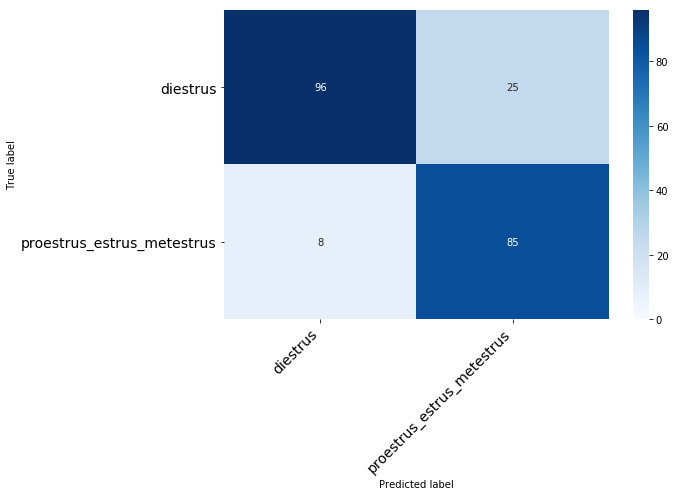

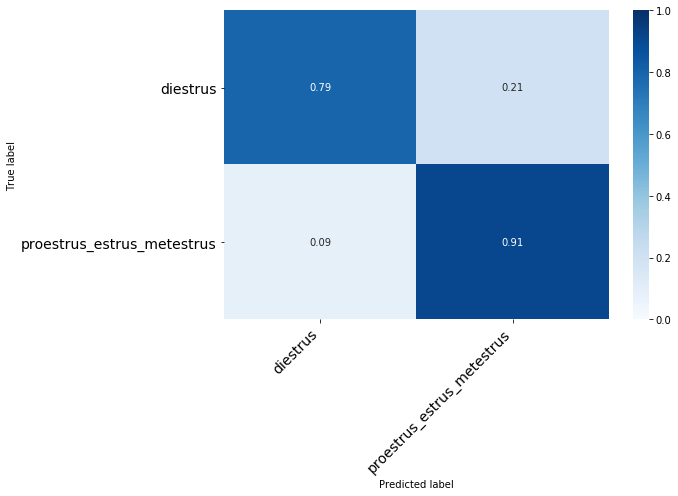

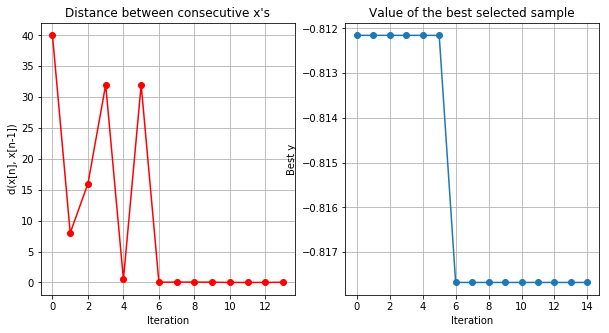

Best params: {'batch_size': 32.0, 'lr_decay': 0.2689977994454577, 'adam_lr': 0.032900208588493365, 'adam_beta1': 0.9313858324817013, 'adam_beta2': 0.9531971940989582, 'adam_wtdecay': 0.4249208280170039}
Iteration BEST, {'batch_size': 32.0, 'lr_decay': 0.2689977994454577, 'adam_lr': 0.032900208588493365, 'adam_beta1': 0.9313858324817013, 'adam_beta2': 0.9531971940989582, 'adam_wtdecay': 0.4249208280170039}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.8066; Associated train accuracy: 0.8564
Writing results to experiments/bayes_opt_2/4_class_tt/nasnetamobile/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 76.72it/s]


3023

nasnetamobile SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.25553808565029124, 'lr': 0.07408944273042967, 'momentum': 0.9304744024464859, 'weight_decay': 0.7163250305646756}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.8929
Iteration 2, {'batch_size': 16.0, 'lr_decay': 0.18568608506253093, 'lr': 0.022878061212391554, 'momentum': 0.6015812850459249, 'weight_decay': 0.8493189182843212}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.9037
Iteration 3, {'batch_size': 64.0, 'lr_decay': 0.17168589725710584, 'lr': 0.03850210688225062, 'momentum': 0.7338411136245877, 'weight_decay': 0.6820621183257138}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9214
Iteration 4, {'batch_size': 64.0, 'lr_decay': 0.09051522494769365, 'lr': 0.053943750802569024, 'momentum': 0.5789621125026766, 'weight_decay': 0.4437354127905031}


Training stopped early at 9 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.8969
Iteration 5, {'batch_size': 16.0, 'lr_decay': 0.10090951618580828, 'lr': 0.03544467783175976, 'momentum': 0.7518670109212123, 'weight_decay': 0.8375629345301728}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.8752
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.19181441975211558, 'lr': 0.03466996328957739, 'momentum': 0.7722650174601935, 'weight_decay': 0.7411870970826265}


Training stopped early at 14 epochs.
Best validation accuracy: 0.8500; Associated train accuracy: 0.9253
Iteration 7, {'batch_size': 48.0, 'lr_decay': 0.2535824514974284, 'lr': 0.041140781048340874, 'momentum': 0.91952454213061, 'weight_decay': 0.7277719549244231}


Training stopped early at 10 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9057
Iteration 8, {'batch_size': 48.0, 'lr_decay': 0.24342611712010226, 'lr': 0.013011776070567426, 'momentum': 0.9009947787968193, 'weight_decay': 0.751241839162972}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9165
Iteration 9, {'batch_size': 48.0, 'lr_decay': 0.2582650578015403, 'lr': 0.03232621431724384, 'momentum': 0.9222364129254108, 'weight_decay': 0.7224309463123731}


Training stopped early at 17 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9303
Iteration 10, {'batch_size': 48.0, 'lr_decay': 0.2525880824644555, 'lr': 0.04622670912354485, 'momentum': 0.919814519085846, 'weight_decay': 0.7281017629086777}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9145
Iteration 11, {'batch_size': 48.0, 'lr_decay': 0.2549370600298969, 'lr': 0.03826625641387388, 'momentum': 0.9202260054587098, 'weight_decay': 0.7263086577634505}


Training stopped early at 15 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9145
Iteration 12, {'batch_size': 48.0, 'lr_decay': 0.2571346827147982, 'lr': 0.03550304978749679, 'momentum': 0.9216842087356633, 'weight_decay': 0.7237913214277928}


Training stopped early at 10 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9018
Iteration 13, {'batch_size': 48.0, 'lr_decay': 0.2589141871376309, 'lr': 0.03275878593701361, 'momentum': 0.9230096265022197, 'weight_decay': 0.7210745704300693}


Training stopped early at 8 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9037
Iteration 14, {'batch_size': 48.0, 'lr_decay': 0.2622243394143578, 'lr': 0.028357502738865732, 'momentum': 0.9252692614568722, 'weight_decay': 0.7173258478020194}


Training stopped early at 11 epochs.
Best validation accuracy: 0.9333; Associated train accuracy: 0.9145
Iteration 15, {'batch_size': 48.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.9576729496020941, 'weight_decay': 0.6600373183728796}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.8949
Best params: [4.80000000e+01 2.62224339e-01 2.83575027e-02 9.25269261e-01
 7.17325848e-01]


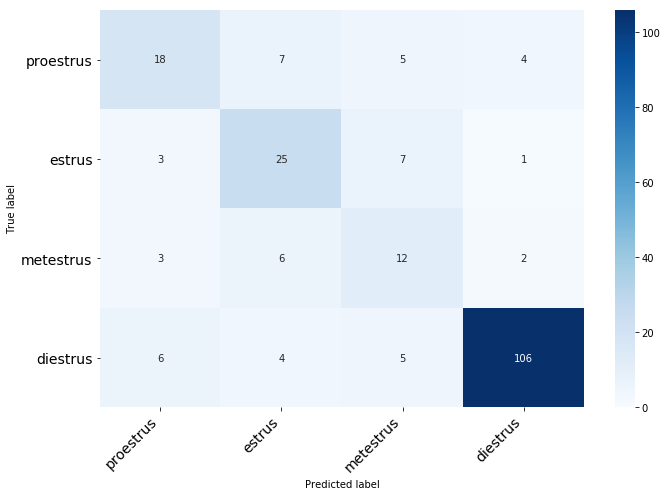

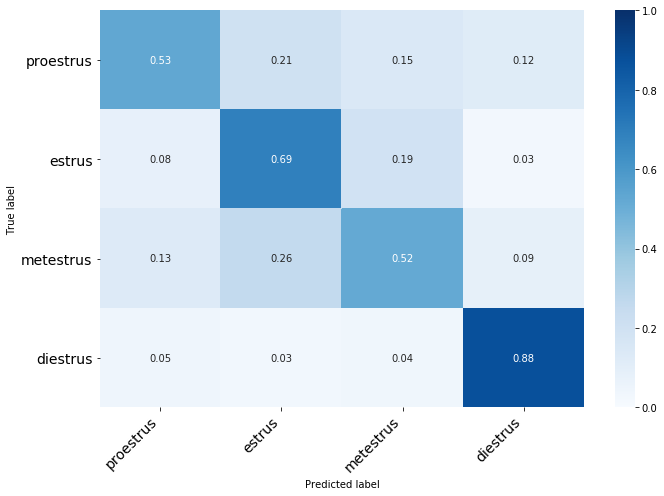

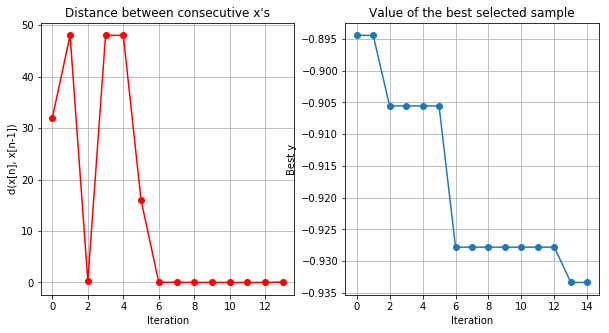

Best params: {'batch_size': 48.0, 'lr_decay': 0.2622243394143578, 'lr': 0.028357502738865732, 'momentum': 0.9252692614568722, 'weight_decay': 0.7173258478020194}
Iteration BEST, {'batch_size': 48.0, 'lr_decay': 0.2622243394143578, 'lr': 0.028357502738865732, 'momentum': 0.9252692614568722, 'weight_decay': 0.7173258478020194}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9222; Associated train accuracy: 0.9303
Writing results to experiments/bayes_opt_2/die_vs_all_tt/nasnetamobile/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 79.39it/s]


48

nasnetamobile SGD data/4_class_tt
Iteration 1, {'batch_size': 32.0, 'lr_decay': 0.12348597453968835, 'lr': 0.01918607262573478, 'momentum': 0.7423150010079145, 'weight_decay': 0.5887354731250721}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8083
Iteration 2, {'batch_size': 32.0, 'lr_decay': 0.2415568486145161, 'lr': 0.09201761365209642, 'momentum': 0.5136968345649516, 'weight_decay': 0.7775923880152151}


Training stopped early at 23 epochs.
Best validation accuracy: 0.7238; Associated train accuracy: 0.8417
Iteration 3, {'batch_size': 48.0, 'lr_decay': 0.11340794844873976, 'lr': 0.06607925371550619, 'momentum': 0.9632931507786708, 'weight_decay': 0.8625534566598747}


Training stopped early at 26 epochs.
Best validation accuracy: 0.7238; Associated train accuracy: 0.7837
Iteration 4, {'batch_size': 48.0, 'lr_decay': 0.0699810136201231, 'lr': 0.030744538039779983, 'momentum': 0.6354162383161273, 'weight_decay': 0.37649497609916993}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7403; Associated train accuracy: 0.8014
Iteration 5, {'batch_size': 16.0, 'lr_decay': 0.13604843072869213, 'lr': 0.06958857737538326, 'momentum': 0.9193342141513723, 'weight_decay': 0.6626319016952408}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7293; Associated train accuracy: 0.7611
Iteration 6, {'batch_size': 32.0, 'lr_decay': 0.12163272640916664, 'lr': 0.038505387001048344, 'momentum': 0.7514020677411424, 'weight_decay': 0.6644724538141561}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7238; Associated train accuracy: 0.8299
Iteration 7, {'batch_size': 24.0, 'lr_decay': 0.10093285709193066, 'lr': 0.09101656619588895, 'momentum': 0.9384412083471265, 'weight_decay': 0.15308513055643092}


Training stopped early at 12 epochs.
Best validation accuracy: 0.5746; Associated train accuracy: 0.5595
Iteration 8, {'batch_size': 64.0, 'lr_decay': 0.127910963921616, 'lr': 0.0028368065378610342, 'momentum': 0.5489391803419664, 'weight_decay': 0.06092695958137173}


Training stopped early at 16 epochs.
Best validation accuracy: 0.6796; Associated train accuracy: 0.7316
Iteration 9, {'batch_size': 32.0, 'lr_decay': 0.03, 'lr': 0.001, 'momentum': 0.99, 'weight_decay': 0.0}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8250
Iteration 10, {'batch_size': 32.0, 'lr_decay': 0.03, 'lr': 0.001, 'momentum': 0.99, 'weight_decay': 0.0}


Training stopped early at 10 epochs.
Best validation accuracy: 0.7735; Associated train accuracy: 0.7719
Best params: [3.2e+01 3.0e-02 1.0e-03 9.9e-01 0.0e+00]


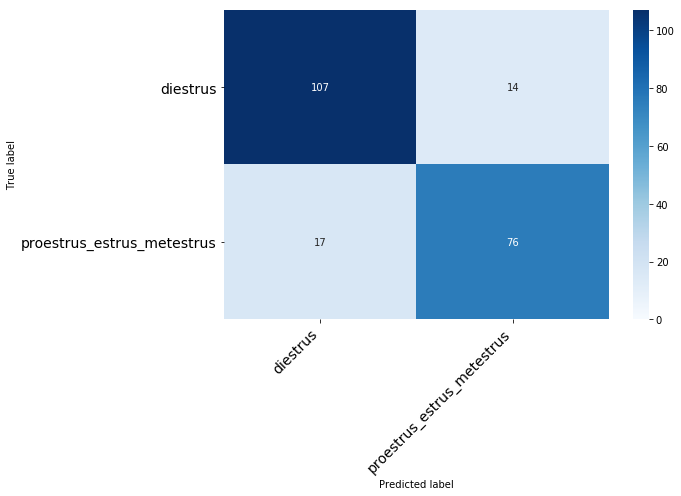

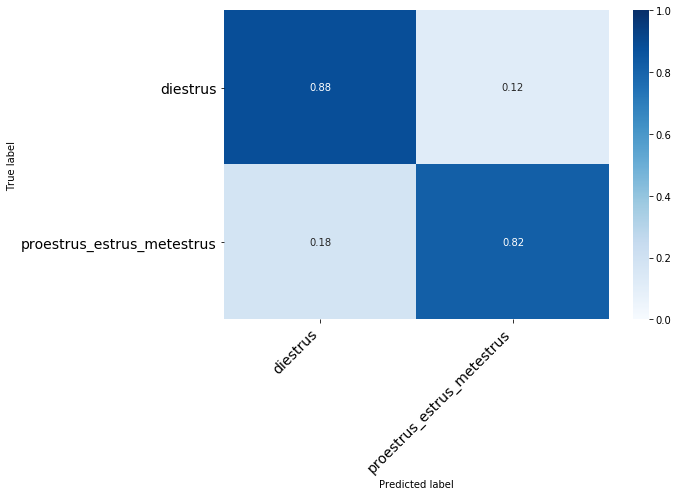

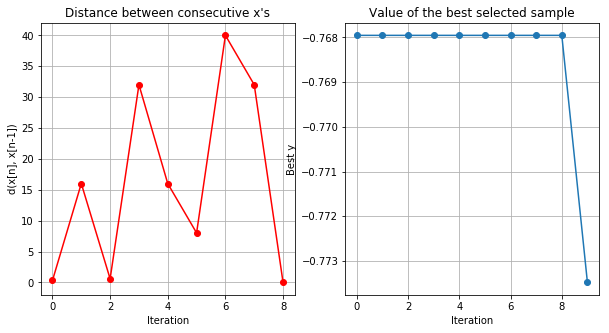

Best params: {'batch_size': 32.0, 'lr_decay': 0.03, 'lr': 0.001, 'momentum': 0.99, 'weight_decay': 0.0}
Iteration BEST, {'batch_size': 32.0, 'lr_decay': 0.03, 'lr': 0.001, 'momentum': 0.99, 'weight_decay': 0.0}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.6961; Associated train accuracy: 0.7866
Writing results to experiments/bayes_opt_2/4_class_tt/nasnetamobile/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 76.14it/s]


15405

se_resnet50 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.09284988004302865, 'adam_lr': 0.022349320844891767, 'adam_beta1': 0.8968313625298799, 'adam_beta2': 0.994501637093455, 'adam_wtdecay': 0.5094357612482715}


Training stopped early at 20 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9528
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.18036190323625245, 'adam_lr': 0.0026708387902587994, 'adam_beta1': 0.8419786895460613, 'adam_beta2': 0.9940550159077238, 'adam_wtdecay': 0.45893224068006755}


Training stopped early at 19 epochs.
Best validation accuracy: 0.8500; Associated train accuracy: 0.9037
Iteration 3, {'batch_size': 48.0, 'lr_decay': 0.2523208549656239, 'adam_lr': 0.017432872724998938, 'adam_beta1': 0.9740466568241815, 'adam_beta2': 0.9567864171054463, 'adam_wtdecay': 0.9789844513833542}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8611; Associated train accuracy: 0.8890
Iteration 4, {'batch_size': 24.0, 'lr_decay': 0.27774517849051306, 'adam_lr': 0.017972246767294663, 'adam_beta1': 0.9363073331898913, 'adam_beta2': 0.9516990371560233, 'adam_wtdecay': 0.8394356271582832}


Training stopped early at 14 epochs.
Best validation accuracy: 0.9222; Associated train accuracy: 0.9470
Iteration 5, {'batch_size': 48.0, 'lr_decay': 0.29874462068988605, 'adam_lr': 0.017595666593256527, 'adam_beta1': 0.9838651413062657, 'adam_beta2': 0.9912437403168514, 'adam_wtdecay': 0.8169835811635145}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.9371
Iteration 6, {'batch_size': 24.0, 'lr_decay': 0.27766821522152607, 'adam_lr': 0.017302349523330703, 'adam_beta1': 0.9351688251161724, 'adam_beta2': 0.9516962907635085, 'adam_wtdecay': 0.8332610692378505}


Training stopped early at 14 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.9283
Iteration 7, {'batch_size': 64.0, 'lr_decay': 0.09284987164858519, 'adam_lr': 0.022349839442097046, 'adam_beta1': 0.8968310924771387, 'adam_beta2': 0.9945019679548045, 'adam_wtdecay': 0.5094357694003182}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.9430
Iteration 8, {'batch_size': 24.0, 'lr_decay': 0.2264499774538855, 'adam_lr': 0.00308152630273834, 'adam_beta1': 0.9459581872714434, 'adam_beta2': 0.9581691307752607, 'adam_wtdecay': 0.8276699132471815}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9167; Associated train accuracy: 0.9018
Iteration 9, {'batch_size': 24.0, 'lr_decay': 0.2453333822286662, 'adam_lr': 0.008832367196362245, 'adam_beta1': 0.9428843637626397, 'adam_beta2': 0.9557926230613351, 'adam_wtdecay': 0.8345595881977819}


Training stopped early at 12 epochs.
Best validation accuracy: 0.9167; Associated train accuracy: 0.9194
Iteration 10, {'batch_size': 24.0, 'lr_decay': 0.22356505976585375, 'adam_lr': 0.003214849717835523, 'adam_beta1': 0.9482294920284103, 'adam_beta2': 0.9585517728926971, 'adam_wtdecay': 0.8362384900202833}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.9224
Iteration 11, {'batch_size': 24.0, 'lr_decay': 0.2714660790943463, 'adam_lr': 0.0036892795292220197, 'adam_beta1': 0.8935166040523366, 'adam_beta2': 0.975201581848182, 'adam_wtdecay': 0.8217348905376541}


Training stopped early at 17 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9273
Iteration 12, {'batch_size': 24.0, 'lr_decay': 0.2297695604016634, 'adam_lr': 0.010013741443898602, 'adam_beta1': 0.873793601904339, 'adam_beta2': 0.9684240179114214, 'adam_wtdecay': 0.8064062296571206}


Training stopped early at 19 epochs.
Best validation accuracy: 0.9333; Associated train accuracy: 0.9528
Iteration 13, {'batch_size': 24.0, 'lr_decay': 0.24897402380115907, 'adam_lr': 0.015177042012397649, 'adam_beta1': 0.8911935158426021, 'adam_beta2': 0.9606121259828908, 'adam_wtdecay': 0.8107792043412269}


Training stopped early at 14 epochs.
Best validation accuracy: 0.9167; Associated train accuracy: 0.9479
Iteration 14, {'batch_size': 24.0, 'lr_decay': 0.2478609760306785, 'adam_lr': 0.02031867575378368, 'adam_beta1': 0.8605128613806781, 'adam_beta2': 0.9609345502665871, 'adam_wtdecay': 0.7947913668690079}


Training stopped early at 22 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9538
Iteration 15, {'batch_size': 24.0, 'lr_decay': 0.2446970084785244, 'adam_lr': 0.03480909088503045, 'adam_beta1': 0.8, 'adam_beta2': 0.9622312822473879, 'adam_wtdecay': 0.7490848337626994}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9430
Best params: [2.40000000e+01 2.29769560e-01 1.00137414e-02 8.73793602e-01
 9.68424018e-01 8.06406230e-01]


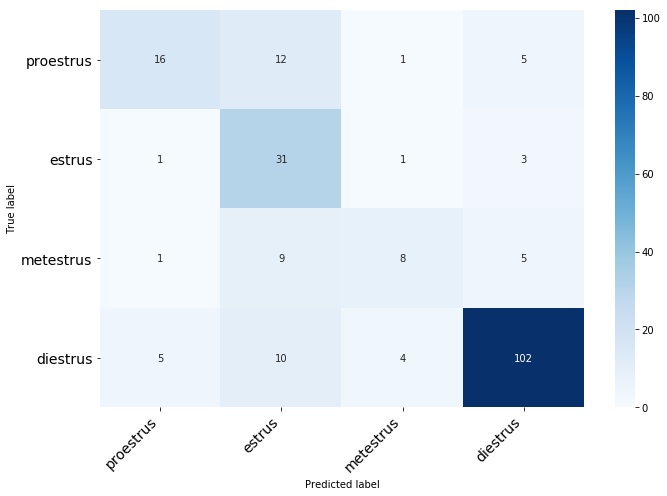

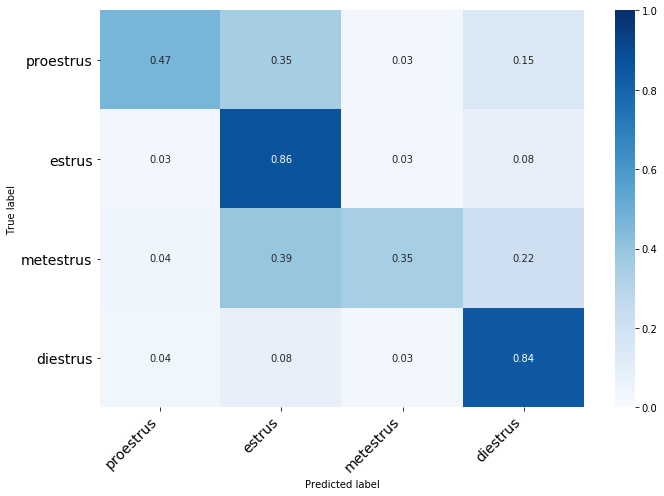

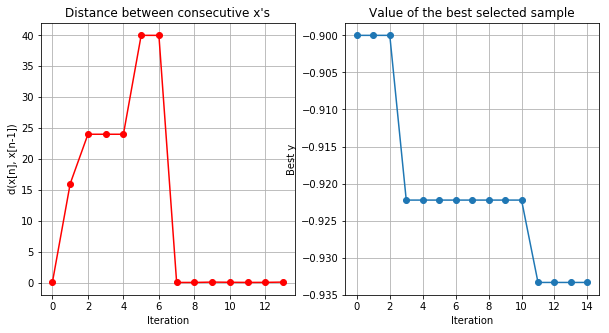

Best params: {'batch_size': 24.0, 'lr_decay': 0.2297695604016634, 'adam_lr': 0.010013741443898602, 'adam_beta1': 0.873793601904339, 'adam_beta2': 0.9684240179114214, 'adam_wtdecay': 0.8064062296571206}
Iteration BEST, {'batch_size': 24.0, 'lr_decay': 0.2297695604016634, 'adam_lr': 0.010013741443898602, 'adam_beta1': 0.873793601904339, 'adam_beta2': 0.9684240179114214, 'adam_wtdecay': 0.8064062296571206}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9111; Associated train accuracy: 0.9303
Writing results to experiments/bayes_opt_2/die_vs_all_tt/se_resnet50/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 80.73it/s]


19509

se_resnet50 Adam data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.20580638537177573, 'adam_lr': 0.08379661437432681, 'adam_beta1': 0.9758457257710693, 'adam_beta2': 0.9940475480649874, 'adam_wtdecay': 0.8974430427349462}


Training stopped early at 21 epochs.
Best validation accuracy: 0.8177; Associated train accuracy: 0.9086
Iteration 2, {'batch_size': 16.0, 'lr_decay': 0.235241729821869, 'adam_lr': 0.0688580827393897, 'adam_beta1': 0.9865788487228138, 'adam_beta2': 0.9863123330498698, 'adam_wtdecay': 0.3731840890108252}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7459; Associated train accuracy: 0.7699
Iteration 3, {'batch_size': 48.0, 'lr_decay': 0.07444839638597317, 'adam_lr': 0.08024508851285614, 'adam_beta1': 0.9251604797048756, 'adam_beta2': 0.9980846461668674, 'adam_wtdecay': 0.16876019613406568}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7956; Associated train accuracy: 0.7984
Iteration 4, {'batch_size': 24.0, 'lr_decay': 0.2510684567257598, 'adam_lr': 0.03679725346111299, 'adam_beta1': 0.8198842639754848, 'adam_beta2': 0.9773734675100421, 'adam_wtdecay': 0.5271810628057226}


Training stopped early at 18 epochs.
Best validation accuracy: 0.7956; Associated train accuracy: 0.9095
Iteration 5, {'batch_size': 32.0, 'lr_decay': 0.0355147927699968, 'adam_lr': 0.07483023988497628, 'adam_beta1': 0.9480550479108822, 'adam_beta2': 0.955680951305098, 'adam_wtdecay': 0.3756961469262875}


Training stopped early at 20 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8525
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.1896523060940064, 'adam_lr': 0.053828842096341874, 'adam_beta1': 0.8300397383887201, 'adam_beta2': 0.9638983464105372, 'adam_wtdecay': 0.5828856442384888}


Training stopped early at 23 epochs.
Best validation accuracy: 0.7956; Associated train accuracy: 0.9174
Iteration 7, {'batch_size': 64.0, 'lr_decay': 0.032118089595182815, 'adam_lr': 0.1, 'adam_beta1': 0.99, 'adam_beta2': 0.9999, 'adam_wtdecay': 1.0}


Training stopped early at 31 epochs.
Best validation accuracy: 0.8122; Associated train accuracy: 0.8830
Iteration 8, {'batch_size': 64.0, 'lr_decay': 0.3, 'adam_lr': 0.001, 'adam_beta1': 0.99, 'adam_beta2': 0.9999, 'adam_wtdecay': 1.0}


Training stopped early at 15 epochs.
Best validation accuracy: 0.6077; Associated train accuracy: 0.5900
Iteration 9, {'batch_size': 64.0, 'lr_decay': 0.19021282615356444, 'adam_lr': 0.07365122353803254, 'adam_beta1': 0.8342109467399963, 'adam_beta2': 0.9684180171149603, 'adam_wtdecay': 0.5869242870403838}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8122; Associated train accuracy: 0.8938
Iteration 10, {'batch_size': 64.0, 'lr_decay': 0.14795051170004375, 'adam_lr': 0.1, 'adam_beta1': 0.9758541160474364, 'adam_beta2': 0.9940814578062317, 'adam_wtdecay': 0.8980738500845711}


Training stopped early at 8 epochs.
Best validation accuracy: 0.7735; Associated train accuracy: 0.7837
Iteration 11, {'batch_size': 64.0, 'lr_decay': 0.2333131203411693, 'adam_lr': 0.0973931700129705, 'adam_beta1': 0.9703227924560913, 'adam_beta2': 0.99179348178893, 'adam_wtdecay': 0.85799800747614}


Training stopped early at 25 epochs.
Best validation accuracy: 0.8122; Associated train accuracy: 0.9312
Iteration 12, {'batch_size': 64.0, 'lr_decay': 0.19519123385000886, 'adam_lr': 0.1, 'adam_beta1': 0.8657170488618593, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.6196190185168066}


Training stopped early at 27 epochs.
Best validation accuracy: 0.7956; Associated train accuracy: 0.9076
Iteration 13, {'batch_size': 64.0, 'lr_decay': 0.17833454933770143, 'adam_lr': 0.1, 'adam_beta1': 0.8229912226159268, 'adam_beta2': 0.9942578490897602, 'adam_wtdecay': 0.5450788354578179}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8987
Iteration 14, {'batch_size': 64.0, 'lr_decay': 0.22307221535236088, 'adam_lr': 0.1, 'adam_beta1': 0.9370358936470689, 'adam_beta2': 0.95, 'adam_wtdecay': 0.8918276071372322}


Training stopped early at 20 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.9036
Iteration 15, {'batch_size': 64.0, 'lr_decay': 0.20640245626987153, 'adam_lr': 0.1, 'adam_beta1': 0.8067142500521394, 'adam_beta2': 0.95, 'adam_wtdecay': 0.6178414288952655}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8619; Associated train accuracy: 0.8948
Best params: [64.          0.20640246  0.1         0.80671425  0.95        0.61784143]


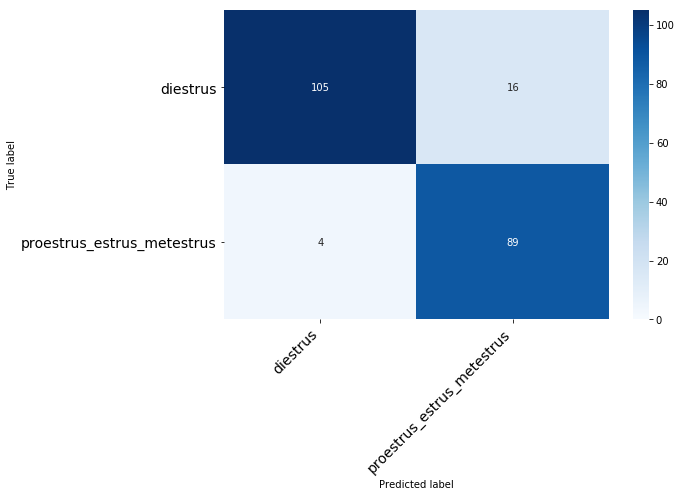

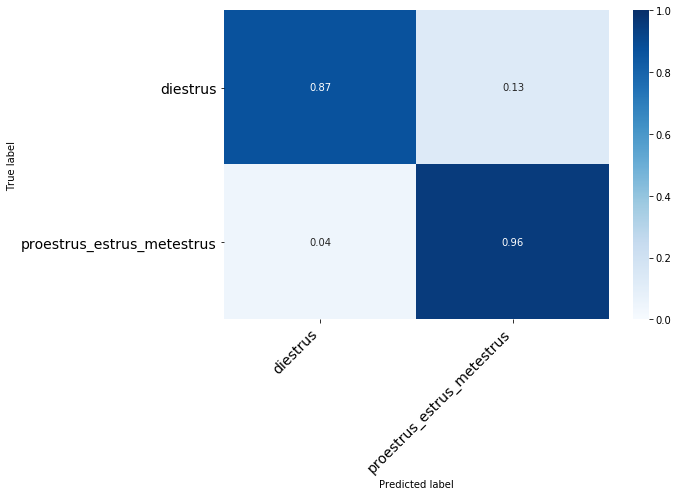

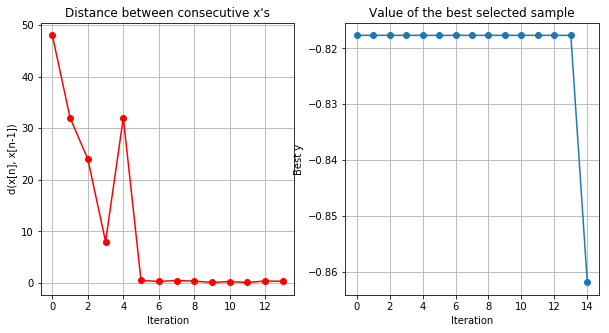

Best params: {'batch_size': 64.0, 'lr_decay': 0.20640245626987153, 'adam_lr': 0.1, 'adam_beta1': 0.8067142500521394, 'adam_beta2': 0.95, 'adam_wtdecay': 0.6178414288952655}
Iteration BEST, {'batch_size': 64.0, 'lr_decay': 0.20640245626987153, 'adam_lr': 0.1, 'adam_beta1': 0.8067142500521394, 'adam_beta2': 0.95, 'adam_wtdecay': 0.6178414288952655}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.7845; Associated train accuracy: 0.9381
Writing results to experiments/bayes_opt_2/4_class_tt/se_resnet50/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 77.30it/s]


18334

se_resnet50 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.031159109436057323, 'lr': 0.07595541498067791, 'momentum': 0.691875095894887, 'weight_decay': 0.8543126690550269}


Training stopped early at 7 epochs.
Best validation accuracy: 0.9222; Associated train accuracy: 0.8615
Iteration 2, {'batch_size': 32.0, 'lr_decay': 0.12030368501394138, 'lr': 0.058302377535346284, 'momentum': 0.5727774817290788, 'weight_decay': 0.8561464175417853}


Training stopped early at 15 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9411
Iteration 3, {'batch_size': 32.0, 'lr_decay': 0.08299345646654654, 'lr': 0.09295257328479738, 'momentum': 0.5921763834684747, 'weight_decay': 0.1545152594337159}


Training stopped early at 18 epochs.
Best validation accuracy: 0.8667; Associated train accuracy: 0.9155
Iteration 4, {'batch_size': 16.0, 'lr_decay': 0.08419495669384433, 'lr': 0.0634478507081959, 'momentum': 0.6945982932439233, 'weight_decay': 0.33739181491658565}


Training stopped early at 12 epochs.
Best validation accuracy: 0.9389; Associated train accuracy: 0.8831
Iteration 5, {'batch_size': 32.0, 'lr_decay': 0.12414531346459447, 'lr': 0.03644303806200139, 'momentum': 0.8190517847098298, 'weight_decay': 0.24811041861152983}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9444; Associated train accuracy: 0.9204
Iteration 6, {'batch_size': 32.0, 'lr_decay': 0.12455393184160617, 'lr': 0.021849024386307103, 'momentum': 0.824795868086885, 'weight_decay': 0.2543627176589002}


Training stopped early at 12 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9283
Iteration 7, {'batch_size': 32.0, 'lr_decay': 0.12362193057715923, 'lr': 0.05513498345829917, 'momentum': 0.8116950703980328, 'weight_decay': 0.24010245078020861}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.8988
Iteration 8, {'batch_size': 32.0, 'lr_decay': 0.11986142393228799, 'lr': 0.05158931332324974, 'momentum': 0.5678265519768498, 'weight_decay': 0.856402857454142}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.9361
Iteration 9, {'batch_size': 48.0, 'lr_decay': 0.21550525282149036, 'lr': 0.09901800865110062, 'momentum': 0.5489144672795829, 'weight_decay': 0.14173921524049382}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9167; Associated train accuracy: 0.9322
Iteration 10, {'batch_size': 24.0, 'lr_decay': 0.1365111088339067, 'lr': 0.03061668040473416, 'momentum': 0.6768728550796164, 'weight_decay': 0.5006563674682508}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.8900
Iteration 11, {'batch_size': 48.0, 'lr_decay': 0.2767728052456278, 'lr': 0.09062288254078035, 'momentum': 0.6710944819460083, 'weight_decay': 0.3941287184525182}


Training stopped early at 20 epochs.
Best validation accuracy: 0.9167; Associated train accuracy: 0.9411
Iteration 12, {'batch_size': 24.0, 'lr_decay': 0.20760787019997684, 'lr': 0.07809384932688952, 'momentum': 0.7659111478656105, 'weight_decay': 0.043611488719104696}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8389; Associated train accuracy: 0.8870
Iteration 13, {'batch_size': 16.0, 'lr_decay': 0.0748519393216542, 'lr': 0.053862114712588643, 'momentum': 0.6142701182580789, 'weight_decay': 0.5484436339968486}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9175
Iteration 14, {'batch_size': 16.0, 'lr_decay': 0.08049463063701516, 'lr': 0.06039629924180987, 'momentum': 0.6689996788121054, 'weight_decay': 0.40510910771557157}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.8988
Iteration 15, {'batch_size': 48.0, 'lr_decay': 0.1505997374163679, 'lr': 0.09075134670945664, 'momentum': 0.6768871342373463, 'weight_decay': 0.5146050500319597}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8611; Associated train accuracy: 0.9440
Best params: [32.          0.12414531  0.03644304  0.81905178  0.24811042]


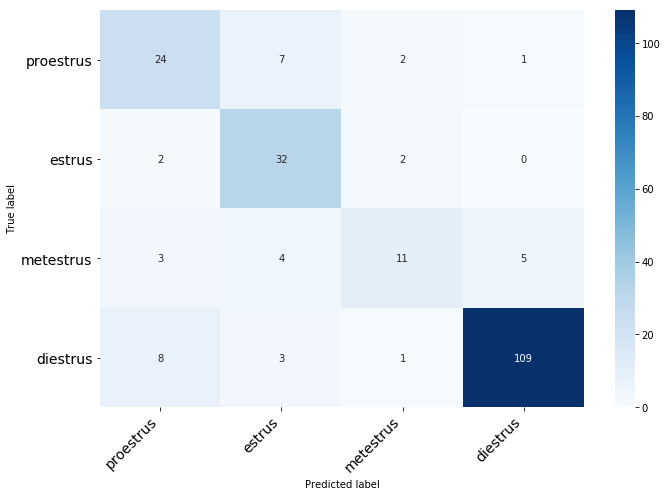

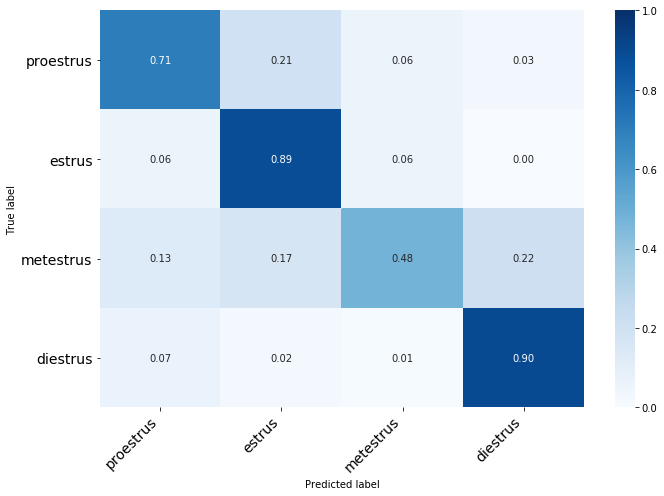

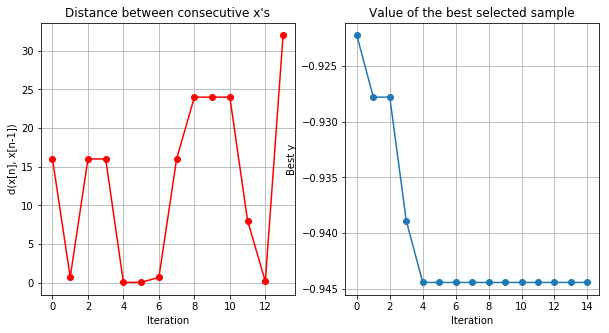

Best params: {'batch_size': 32.0, 'lr_decay': 0.12414531346459447, 'lr': 0.03644303806200139, 'momentum': 0.8190517847098298, 'weight_decay': 0.24811041861152983}
Iteration BEST, {'batch_size': 32.0, 'lr_decay': 0.12414531346459447, 'lr': 0.03644303806200139, 'momentum': 0.8190517847098298, 'weight_decay': 0.24811041861152983}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9167; Associated train accuracy: 0.9450
Writing results to experiments/bayes_opt_2/die_vs_all_tt/se_resnet50/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 79.96it/s]


16143

se_resnet50 SGD data/4_class_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.13318228124661058, 'lr': 0.09508834475473228, 'momentum': 0.8266257706757507, 'weight_decay': 0.3758987857090551}


Training stopped early at 8 epochs.
Best validation accuracy: 0.6961; Associated train accuracy: 0.7207
Iteration 2, {'batch_size': 24.0, 'lr_decay': 0.22084149464285446, 'lr': 0.05055135843916824, 'momentum': 0.9545772994220652, 'weight_decay': 0.6862237891034771}


Training stopped early at 13 epochs.
Best validation accuracy: 0.7348; Associated train accuracy: 0.7434
Iteration 3, {'batch_size': 48.0, 'lr_decay': 0.057200397220045954, 'lr': 0.03889130222980573, 'momentum': 0.6032768271727573, 'weight_decay': 0.5110563599459055}


Training stopped early at 26 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.9027
Iteration 4, {'batch_size': 48.0, 'lr_decay': 0.06540786897136472, 'lr': 0.06032719404211839, 'momentum': 0.6289410540581376, 'weight_decay': 0.005796148666054712}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7293; Associated train accuracy: 0.8741
Iteration 5, {'batch_size': 64.0, 'lr_decay': 0.21085378436830313, 'lr': 0.024770115458962808, 'momentum': 0.6161268918089177, 'weight_decay': 0.9701485189567921}


Training stopped early at 13 epochs.
Best validation accuracy: 0.7127; Associated train accuracy: 0.7434
Iteration 6, {'batch_size': 32.0, 'lr_decay': 0.12154970648322815, 'lr': 0.08213647815640455, 'momentum': 0.6441913412805153, 'weight_decay': 0.08261399407855341}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8417
Iteration 7, {'batch_size': 48.0, 'lr_decay': 0.071044714177049, 'lr': 0.03306326704654335, 'momentum': 0.8468395497484233, 'weight_decay': 0.07025786674747558}


Training stopped early at 26 epochs.
Best validation accuracy: 0.8232; Associated train accuracy: 0.8938
Iteration 8, {'batch_size': 32.0, 'lr_decay': 0.0639527050164293, 'lr': 0.08759278672610794, 'momentum': 0.9804469086981331, 'weight_decay': 0.6111593179217598}


Training stopped early at 13 epochs.
Best validation accuracy: 0.6740; Associated train accuracy: 0.7168
Iteration 9, {'batch_size': 32.0, 'lr_decay': 0.21631698160804927, 'lr': 0.04166243715379225, 'momentum': 0.9857856638805484, 'weight_decay': 0.4426313453066101}


Training stopped early at 9 epochs.
Best validation accuracy: 0.6354; Associated train accuracy: 0.6509
Iteration 10, {'batch_size': 48.0, 'lr_decay': 0.04171151937197627, 'lr': 0.02730415617334213, 'momentum': 0.5591487256061412, 'weight_decay': 0.5363718316730215}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7403; Associated train accuracy: 0.8535
Iteration 11, {'batch_size': 48.0, 'lr_decay': 0.0335222681454679, 'lr': 0.007544022294722863, 'momentum': 0.6832873349986106, 'weight_decay': 0.30752807155319295}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8299
Iteration 12, {'batch_size': 48.0, 'lr_decay': 0.03, 'lr': 0.001, 'momentum': 0.655438501067816, 'weight_decay': 0.33232432219556807}


Training stopped early at 13 epochs.
Best validation accuracy: 0.7127; Associated train accuracy: 0.7581
Iteration 13, {'batch_size': 48.0, 'lr_decay': 0.03704754647798105, 'lr': 0.012117814750391974, 'momentum': 0.6921533690382176, 'weight_decay': 0.2996320525401619}


Training stopped early at 16 epochs.
Best validation accuracy: 0.7569; Associated train accuracy: 0.8643
Iteration 14, {'batch_size': 48.0, 'lr_decay': 0.03, 'lr': 0.003490591129081749, 'momentum': 0.6904713666219787, 'weight_decay': 0.29836403744840073}


Training stopped early at 8 epochs.
Best validation accuracy: 0.7459; Associated train accuracy: 0.7207
Iteration 15, {'batch_size': 48.0, 'lr_decay': 0.06248656267671782, 'lr': 0.04290810357902691, 'momentum': 0.6179446912477388, 'weight_decay': 0.5030940816777775}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8287; Associated train accuracy: 0.8368
Best params: [4.80000000e+01 5.72003972e-02 3.88913022e-02 6.03276827e-01
 5.11056360e-01]


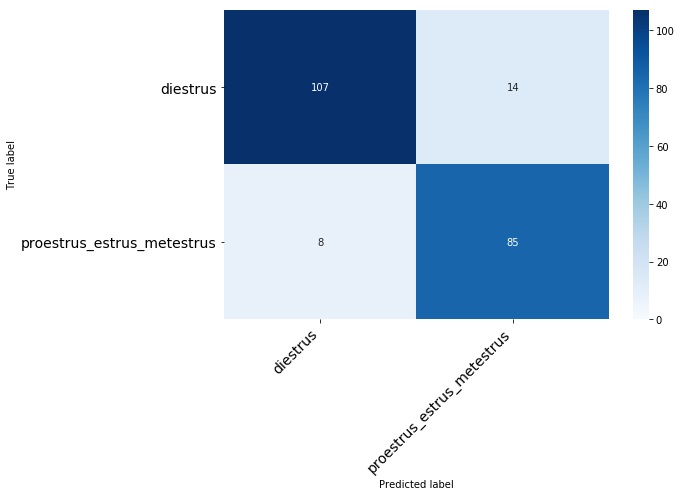

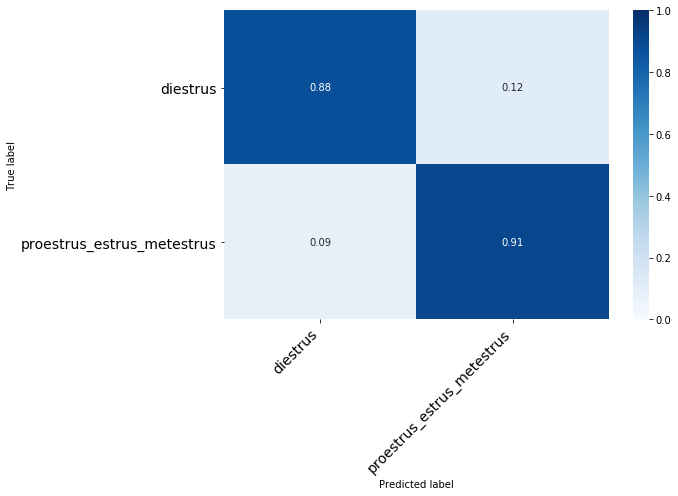

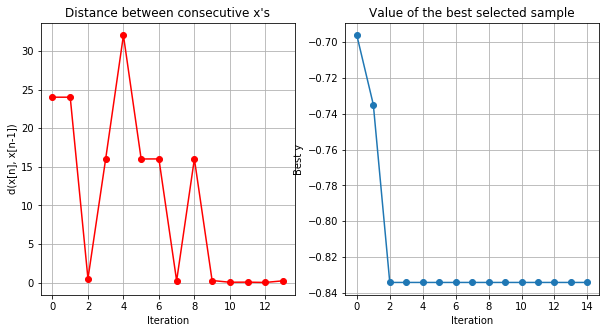

Best params: {'batch_size': 48.0, 'lr_decay': 0.057200397220045954, 'lr': 0.03889130222980573, 'momentum': 0.6032768271727573, 'weight_decay': 0.5110563599459055}
Iteration BEST, {'batch_size': 48.0, 'lr_decay': 0.057200397220045954, 'lr': 0.03889130222980573, 'momentum': 0.6032768271727573, 'weight_decay': 0.5110563599459055}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.8232; Associated train accuracy: 0.9282
Writing results to experiments/bayes_opt_2/4_class_tt/se_resnet50/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 76.66it/s]


15410

se_resnet101 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 32.0, 'lr_decay': 0.09521995124582142, 'adam_lr': 0.011537761600170497, 'adam_beta1': 0.9710060062744548, 'adam_beta2': 0.9795483090001817, 'adam_wtdecay': 0.6690513710454432}


Training stopped early at 23 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9381
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.03608568094078901, 'adam_lr': 0.01642471841654439, 'adam_beta1': 0.8255900857379359, 'adam_beta2': 0.9930245291033067, 'adam_wtdecay': 0.22847292902988336}


Training stopped early at 10 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9086
Iteration 3, {'batch_size': 64.0, 'lr_decay': 0.22404842703268035, 'adam_lr': 0.05370279879663586, 'adam_beta1': 0.9328225157424022, 'adam_beta2': 0.9918486251621929, 'adam_wtdecay': 0.9865061518724495}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9528
Iteration 4, {'batch_size': 16.0, 'lr_decay': 0.11142320465788942, 'adam_lr': 0.08884795064998886, 'adam_beta1': 0.958971233181319, 'adam_beta2': 0.991276977749518, 'adam_wtdecay': 0.4471479453053623}


Training stopped early at 22 epochs.
Best validation accuracy: 0.8667; Associated train accuracy: 0.8664
Iteration 5, {'batch_size': 48.0, 'lr_decay': 0.20140307300038945, 'adam_lr': 0.011688842884640508, 'adam_beta1': 0.804243913732814, 'adam_beta2': 0.953357768134086, 'adam_wtdecay': 0.5431117735497389}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9499
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.3, 'adam_lr': 0.1, 'adam_beta1': 0.99, 'adam_beta2': 0.95, 'adam_wtdecay': 0.0}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 33, in perform_bayesian_optimization
    problem.run_optimization(max_iter=MAX_ITERATIONS)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/bo.py", line 149, in run_optimization
    self.evaluate_objective()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/bo.py", line 195, in evaluate_objective
    self.Y_new, cost_new = self.objective.evaluate(self.suggested_sample)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/

3864

se_resnet101 Adam data/4_class_tt
Iteration 1, {'batch_size': 24.0, 'lr_decay': 0.25421482296926573, 'adam_lr': 0.03644422051638878, 'adam_beta1': 0.9111987718401887, 'adam_beta2': 0.9520277655663367, 'adam_wtdecay': 0.8812058461237006}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

457

se_resnet101 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.20416958687176662, 'lr': 0.013757133381660864, 'momentum': 0.7011929454812067, 'weight_decay': 0.02547164403416602}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9499
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.24005376845850748, 'lr': 0.09536458475062316, 'momentum': 0.7568635207805723, 'weight_decay': 0.023155505657996622}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8667; Associated train accuracy: 0.9234
Iteration 3, {'batch_size': 24.0, 'lr_decay': 0.08109810118568336, 'lr': 0.03509823804361217, 'momentum': 0.90219848706832, 'weight_decay': 0.3638028064636535}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.8782
Iteration 4, {'batch_size': 32.0, 'lr_decay': 0.03355512192529567, 'lr': 0.04560026967737891, 'momentum': 0.7650985634768495, 'weight_decay': 0.24900637737148923}


Training stopped early at 9 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.9028
Iteration 5, {'batch_size': 24.0, 'lr_decay': 0.05929840713842424, 'lr': 0.0923413122912615, 'momentum': 0.6072584553273308, 'weight_decay': 0.7983021339959303}


Training stopped early at 11 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9303
Iteration 6, {'batch_size': 24.0, 'lr_decay': 0.04863350862626481, 'lr': 0.025222096173508173, 'momentum': 0.9550706432702862, 'weight_decay': 0.5431432253438457}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.8978
Iteration 7, {'batch_size': 64.0, 'lr_decay': 0.15919582377029465, 'lr': 0.01999583558549412, 'momentum': 0.7100276412852647, 'weight_decay': 0.3532484041056576}


Training stopped early at 19 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9637
Iteration 8, {'batch_size': 64.0, 'lr_decay': 0.1458980439327532, 'lr': 0.001, 'momentum': 0.6962442088296439, 'weight_decay': 0.38234997803589776}


Training stopped early at 14 epochs.
Best validation accuracy: 0.8389; Associated train accuracy: 0.9086
Iteration 9, {'batch_size': 64.0, 'lr_decay': 0.2058139282259809, 'lr': 0.015219843657223411, 'momentum': 0.6566605983082325, 'weight_decay': 0.04909146819892818}


Training stopped early at 14 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9499
Iteration 10, {'batch_size': 24.0, 'lr_decay': 0.04616904195107834, 'lr': 0.04409901431690947, 'momentum': 0.6267479628711072, 'weight_decay': 0.8050043843726175}


Training stopped early at 9 epochs.
Best validation accuracy: 0.9500; Associated train accuracy: 0.9214
Iteration 11, {'batch_size': 24.0, 'lr_decay': 0.07618646194835474, 'lr': 0.09550561009553267, 'momentum': 0.5878974067040614, 'weight_decay': 0.822680884788943}


Training stopped early at 14 epochs.
Best validation accuracy: 0.9333; Associated train accuracy: 0.9342
Iteration 12, {'batch_size': 24.0, 'lr_decay': 0.05713266042055921, 'lr': 0.06402434639233065, 'momentum': 0.6096374966692342, 'weight_decay': 0.8136912859221044}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9322
Iteration 13, {'batch_size': 24.0, 'lr_decay': 0.05795292993252534, 'lr': 0.06715789204362832, 'momentum': 0.6086881440127383, 'weight_decay': 0.8129338335636721}


Training stopped early at 20 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9460
Iteration 14, {'batch_size': 24.0, 'lr_decay': 0.05756683089216517, 'lr': 0.06565721915103805, 'momentum': 0.6084870178352025, 'weight_decay': 0.813989039564798}


Training stopped early at 9 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.9253
Iteration 15, {'batch_size': 24.0, 'lr_decay': 0.05834730108103912, 'lr': 0.06866255200215923, 'momentum': 0.6082614661999973, 'weight_decay': 0.8125400101744102}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9312
Best params: [24.          0.04616904  0.04409901  0.62674796  0.80500438]


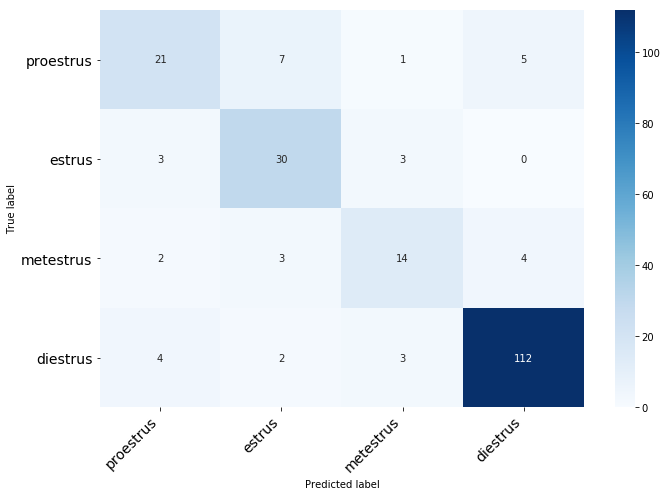

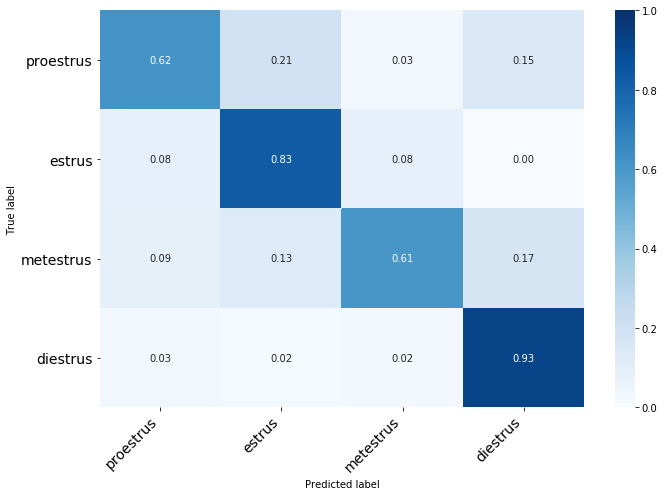

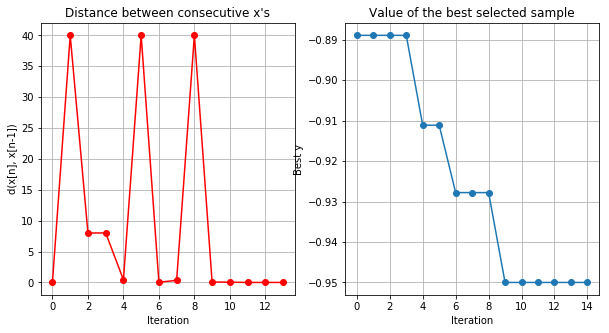

Best params: {'batch_size': 24.0, 'lr_decay': 0.04616904195107834, 'lr': 0.04409901431690947, 'momentum': 0.6267479628711072, 'weight_decay': 0.8050043843726175}
Iteration BEST, {'batch_size': 24.0, 'lr_decay': 0.04616904195107834, 'lr': 0.04409901431690947, 'momentum': 0.6267479628711072, 'weight_decay': 0.8050043843726175}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9389; Associated train accuracy: 0.9401
Writing results to experiments/bayes_opt_2/die_vs_all_tt/se_resnet101/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 78.10it/s]


735

se_resnet101 SGD data/4_class_tt
Iteration 1, {'batch_size': 16.0, 'lr_decay': 0.1758076962924773, 'lr': 0.00501748632670955, 'momentum': 0.9710902179862515, 'weight_decay': 0.338841685255614}


Training stopped early at 26 epochs.
Best validation accuracy: 0.7790; Associated train accuracy: 0.8564
Iteration 2, {'batch_size': 32.0, 'lr_decay': 0.05936514445697903, 'lr': 0.028598636465667116, 'momentum': 0.8423347209240637, 'weight_decay': 0.41628339863674435}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8938
Iteration 3, {'batch_size': 24.0, 'lr_decay': 0.12442153106489663, 'lr': 0.08420492535693902, 'momentum': 0.5714445256502969, 'weight_decay': 0.15205630949779292}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7569; Associated train accuracy: 0.8496
Iteration 4, {'batch_size': 64.0, 'lr_decay': 0.06478654271913087, 'lr': 0.09568997410444957, 'momentum': 0.983870405431133, 'weight_decay': 0.9511866872678487}


Training stopped early at 12 epochs.
Best validation accuracy: 0.6575; Associated train accuracy: 0.6952
Iteration 5, {'batch_size': 24.0, 'lr_decay': 0.28759719778624115, 'lr': 0.015506810643003813, 'momentum': 0.6803143266699159, 'weight_decay': 0.1672325025718362}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8011; Associated train accuracy: 0.8456
Iteration 6, {'batch_size': 16.0, 'lr_decay': 0.3, 'lr': 0.0010000000000000009, 'momentum': 0.5, 'weight_decay': 1.0}


Training stopped early at 8 epochs.
Best validation accuracy: 0.3149; Associated train accuracy: 0.4022
Iteration 7, {'batch_size': 24.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.99, 'weight_decay': 0.34304690773812857}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8505
Iteration 8, {'batch_size': 16.0, 'lr_decay': 0.03, 'lr': 0.022023336434068782, 'momentum': 0.99, 'weight_decay': 0.0}


Training stopped early at 9 epochs.
Best validation accuracy: 0.5635; Associated train accuracy: 0.5526
Iteration 9, {'batch_size': 24.0, 'lr_decay': 0.2496912087996228, 'lr': 0.001011603907722976, 'momentum': 0.9298220337939129, 'weight_decay': 0.04398876413459086}


Training stopped early at 19 epochs.
Best validation accuracy: 0.7956; Associated train accuracy: 0.8830
Iteration 10, {'batch_size': 24.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.6417861878865461, 'weight_decay': 0.5749011785488094}


Training stopped early at 19 epochs.
Best validation accuracy: 0.7238; Associated train accuracy: 0.7502
Iteration 11, {'batch_size': 32.0, 'lr_decay': 0.09613199778588456, 'lr': 0.07291535701043984, 'momentum': 0.7817511982326943, 'weight_decay': 0.9289824140696382}


Training stopped early at 21 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8918
Iteration 12, {'batch_size': 32.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.5, 'weight_decay': 0.7258085626749229}


Training stopped early at 24 epochs.
Best validation accuracy: 0.6464; Associated train accuracy: 0.7188
Iteration 13, {'batch_size': 32.0, 'lr_decay': 0.03, 'lr': 0.1, 'momentum': 0.99, 'weight_decay': 0.7941576055360389}


Training stopped early at 11 epochs.
Best validation accuracy: 0.5746; Associated train accuracy: 0.5742
Iteration 14, {'batch_size': 24.0, 'lr_decay': 0.2396715877737047, 'lr': 0.021980923510577996, 'momentum': 0.8477253426586417, 'weight_decay': 0.21119642032538904}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8181
Iteration 15, {'batch_size': 32.0, 'lr_decay': 0.034661706213623474, 'lr': 0.07601824636657377, 'momentum': 0.6364072856867629, 'weight_decay': 1.0}


Training stopped early at 7 epochs.
Best validation accuracy: 0.5635; Associated train accuracy: 0.5634
Best params: [2.40000000e+01 2.87597198e-01 1.55068106e-02 6.80314327e-01
 1.67232503e-01]


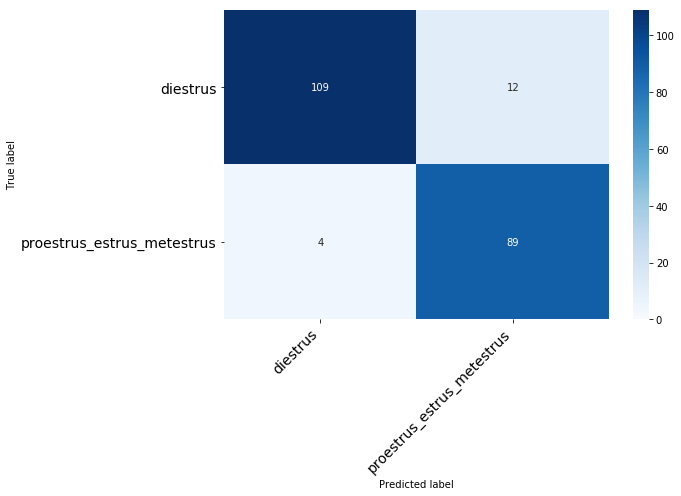

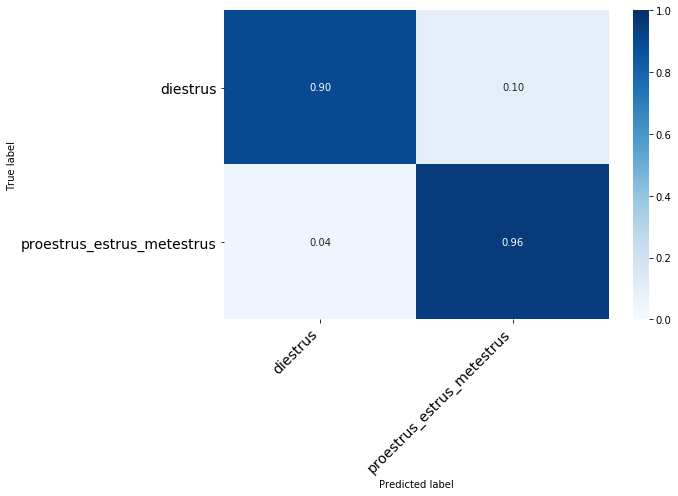

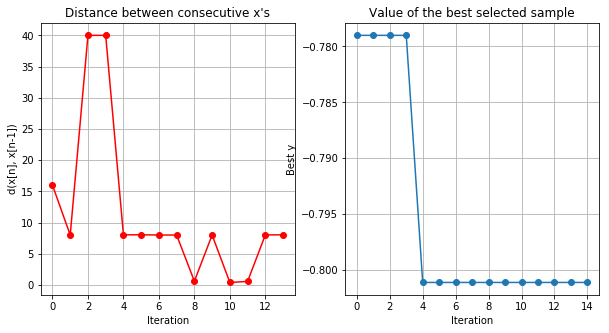

Best params: {'batch_size': 24.0, 'lr_decay': 0.28759719778624115, 'lr': 0.015506810643003813, 'momentum': 0.6803143266699159, 'weight_decay': 0.1672325025718362}
Iteration BEST, {'batch_size': 24.0, 'lr_decay': 0.28759719778624115, 'lr': 0.015506810643003813, 'momentum': 0.6803143266699159, 'weight_decay': 0.1672325025718362}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.8066; Associated train accuracy: 0.8948
Writing results to experiments/bayes_opt_2/4_class_tt/se_resnet101/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 75.57it/s]


2743

inceptionresnetv2 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.03437711910259365, 'adam_lr': 0.03956481868770766, 'adam_beta1': 0.8598561498632474, 'adam_beta2': 0.9604348530004855, 'adam_wtdecay': 0.9237338505915881}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

0

inceptionresnetv2 Adam data/4_class_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.11141405781978655, 'adam_lr': 0.061269287330719784, 'adam_beta1': 0.8613179728177304, 'adam_beta2': 0.9876313700600887, 'adam_wtdecay': 0.397491517673509}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

705

inceptionresnetv2 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 32.0, 'lr_decay': 0.18679196373185242, 'lr': 0.02577209427770021, 'momentum': 0.9806041908363488, 'weight_decay': 0.7953061245011502}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

705

inceptionresnetv2 SGD data/4_class_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.04702927854439777, 'lr': 0.06814243508225792, 'momentum': 0.8229837536371474, 'weight_decay': 0.8937372247013582}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

705

inceptionv4 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.1525257979919974, 'adam_lr': 0.02727489413257088, 'adam_beta1': 0.8891282115063944, 'adam_beta2': 0.9777545292927281, 'adam_wtdecay': 0.6177913579861273}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

705

inceptionv4 Adam data/4_class_tt
Iteration 1, {'batch_size': 16.0, 'lr_decay': 0.15499888960963187, 'adam_lr': 0.08612435784738806, 'adam_beta1': 0.9734800143450553, 'adam_beta2': 0.9684202416257427, 'adam_wtdecay': 0.9800375049445414}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

460

inceptionv4 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.10473218600097327, 'lr': 0.025257713217782574, 'momentum': 0.7748278613384529, 'weight_decay': 0.41851326096797903}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

460

inceptionv4 SGD data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.10230184852786908, 'lr': 0.09153738106300792, 'momentum': 0.8548047357489078, 'weight_decay': 0.738009751254143}


Skipping because Given input size: (1536x5x5). Calculated output size: (1536x0x0). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

460

resnet101 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 32.0, 'lr_decay': 0.04730014748681115, 'adam_lr': 0.08460575297394611, 'adam_beta1': 0.8884243483679355, 'adam_beta2': 0.990566727416581, 'adam_wtdecay': 0.20700584538602584}


Training stopped early at 9 epochs.
Best validation accuracy: 0.7778; Associated train accuracy: 0.7957
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.08099035086185896, 'adam_lr': 0.04096501547544382, 'adam_beta1': 0.9541994209070042, 'adam_beta2': 0.9597398783919926, 'adam_wtdecay': 0.40397607194654517}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.9126
Iteration 3, {'batch_size': 16.0, 'lr_decay': 0.06851500464785562, 'adam_lr': 0.07926197134139684, 'adam_beta1': 0.9747228517849189, 'adam_beta2': 0.9573178863193659, 'adam_wtdecay': 0.9765427615539499}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.8939
Iteration 4, {'batch_size': 32.0, 'lr_decay': 0.1240025048467787, 'adam_lr': 0.06181021674599135, 'adam_beta1': 0.9721833190283583, 'adam_beta2': 0.9573527271186645, 'adam_wtdecay': 0.3432137336696346}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.8949
Iteration 5, {'batch_size': 64.0, 'lr_decay': 0.06941134777963733, 'adam_lr': 0.03141303338084724, 'adam_beta1': 0.8150413405832151, 'adam_beta2': 0.980236955443907, 'adam_wtdecay': 0.8961610467740002}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8667; Associated train accuracy: 0.9224
Iteration 6, {'batch_size': 16.0, 'lr_decay': 0.0708080532849664, 'adam_lr': 0.07903396043565888, 'adam_beta1': 0.971078468372808, 'adam_beta2': 0.965777230199004, 'adam_wtdecay': 0.9646338634124035}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.8694
Iteration 7, {'batch_size': 64.0, 'lr_decay': 0.08821053342439229, 'adam_lr': 0.051813372470971786, 'adam_beta1': 0.9471840005024201, 'adam_beta2': 0.9652457073918786, 'adam_wtdecay': 0.4048386941982619}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.8792
Iteration 8, {'batch_size': 64.0, 'lr_decay': 0.061431875874332395, 'adam_lr': 0.07677561388471638, 'adam_beta1': 0.9732055462763542, 'adam_beta2': 0.960920757457194, 'adam_wtdecay': 0.40931493600691343}


Training stopped early at 11 epochs.
Best validation accuracy: 0.9333; Associated train accuracy: 0.9116
Iteration 9, {'batch_size': 64.0, 'lr_decay': 0.051880272894024804, 'adam_lr': 0.08930336160442442, 'adam_beta1': 0.982487270380041, 'adam_beta2': 0.9602728009001573, 'adam_wtdecay': 0.4113378476906694}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8278; Associated train accuracy: 0.9057
Iteration 10, {'batch_size': 64.0, 'lr_decay': 0.03307631620420735, 'adam_lr': 0.06588165226218656, 'adam_beta1': 0.9715880833195374, 'adam_beta2': 0.969857290852332, 'adam_wtdecay': 0.4177254279878936}


Training stopped early at 9 epochs.
Best validation accuracy: 0.9222; Associated train accuracy: 0.8733
Iteration 11, {'batch_size': 64.0, 'lr_decay': 0.06854701092029238, 'adam_lr': 0.035913517655353576, 'adam_beta1': 0.9669568128188857, 'adam_beta2': 0.9808743682358858, 'adam_wtdecay': 0.4180373915854463}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9214
Iteration 12, {'batch_size': 64.0, 'lr_decay': 0.05474770181259821, 'adam_lr': 0.053566528742830875, 'adam_beta1': 0.964872123364072, 'adam_beta2': 0.9704328920551363, 'adam_wtdecay': 0.41371904789722597}


Training stopped early at 14 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9411
Iteration 13, {'batch_size': 64.0, 'lr_decay': 0.04689679109456641, 'adam_lr': 0.04896185218814539, 'adam_beta1': 0.9641622472043438, 'adam_beta2': 0.9737332888407975, 'adam_wtdecay': 0.41638699499248744}


Training stopped early at 11 epochs.
Best validation accuracy: 0.9000; Associated train accuracy: 0.9155
Iteration 14, {'batch_size': 64.0, 'lr_decay': 0.04696427838238508, 'adam_lr': 0.05569647792933004, 'adam_beta1': 0.9662207755173868, 'adam_beta2': 0.9710869619425557, 'adam_wtdecay': 0.41557986390554835}


Training stopped early at 15 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9460
Iteration 15, {'batch_size': 64.0, 'lr_decay': 0.06405169145862531, 'adam_lr': 0.07014602864997546, 'adam_beta1': 0.9690131917733109, 'adam_beta2': 0.9620075883791733, 'adam_wtdecay': 0.4090024812266606}


Training stopped early at 11 epochs.
Best validation accuracy: 0.9389; Associated train accuracy: 0.9204
Best params: [64.          0.06405169  0.07014603  0.96901319  0.96200759  0.40900248]


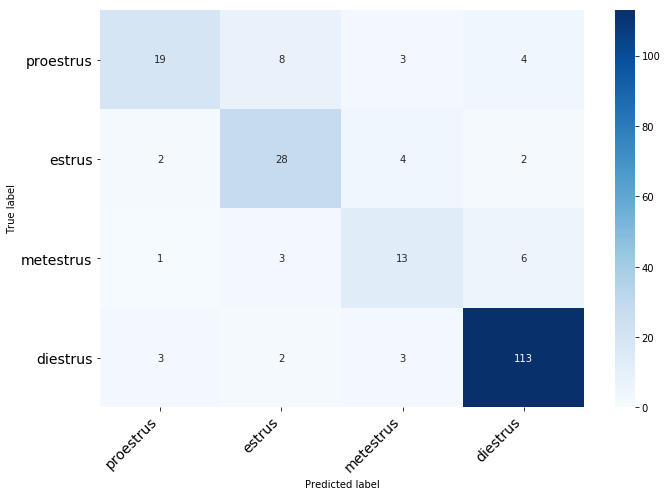

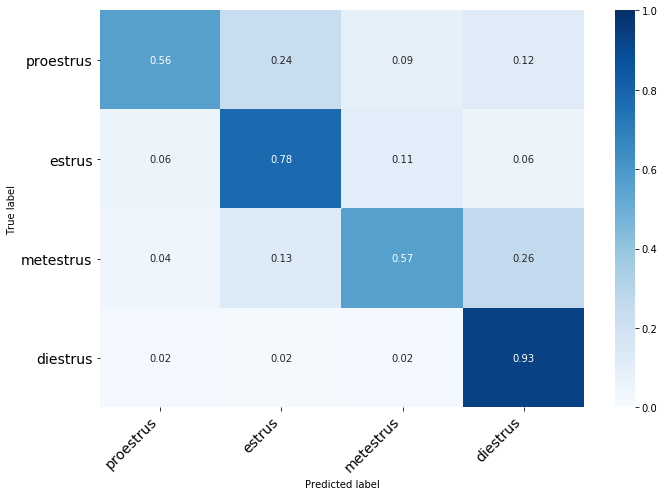

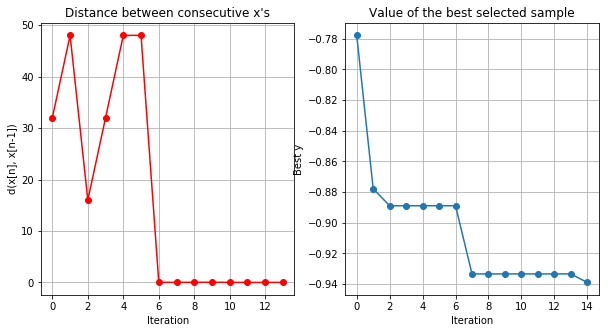

Best params: {'batch_size': 64.0, 'lr_decay': 0.06405169145862531, 'adam_lr': 0.07014602864997546, 'adam_beta1': 0.9690131917733109, 'adam_beta2': 0.9620075883791733, 'adam_wtdecay': 0.4090024812266606}
Iteration BEST, {'batch_size': 64.0, 'lr_decay': 0.06405169145862531, 'adam_lr': 0.07014602864997546, 'adam_beta1': 0.9690131917733109, 'adam_beta2': 0.9620075883791733, 'adam_wtdecay': 0.4090024812266606}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.8889; Associated train accuracy: 0.9263
Writing results to experiments/bayes_opt_2/die_vs_all_tt/resnet101/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 78.00it/s]


1418

resnet101 Adam data/4_class_tt
Iteration 1, {'batch_size': 24.0, 'lr_decay': 0.25035534277814386, 'adam_lr': 0.07576417911818038, 'adam_beta1': 0.9150627550108185, 'adam_beta2': 0.9873310925168555, 'adam_wtdecay': 0.537099383579364}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7459; Associated train accuracy: 0.8043
Iteration 2, {'batch_size': 16.0, 'lr_decay': 0.06845261057906316, 'adam_lr': 0.026304096196689945, 'adam_beta1': 0.817895574917647, 'adam_beta2': 0.9591024704805381, 'adam_wtdecay': 0.453620019968093}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7790; Associated train accuracy: 0.8535
Iteration 3, {'batch_size': 24.0, 'lr_decay': 0.059427980290777366, 'adam_lr': 0.042491254470177105, 'adam_beta1': 0.9521300563817753, 'adam_beta2': 0.9727812724685848, 'adam_wtdecay': 0.03050684432684192}


Training stopped early at 13 epochs.
Best validation accuracy: 0.5691; Associated train accuracy: 0.5654
Iteration 4, {'batch_size': 64.0, 'lr_decay': 0.11536812062702188, 'adam_lr': 0.05344037850255675, 'adam_beta1': 0.8723341253595566, 'adam_beta2': 0.958634089159281, 'adam_wtdecay': 0.9323112115197796}


Training stopped early at 22 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.8899
Iteration 5, {'batch_size': 64.0, 'lr_decay': 0.07046299231821904, 'adam_lr': 0.08896816457724249, 'adam_beta1': 0.968001169545891, 'adam_beta2': 0.9993734851778652, 'adam_wtdecay': 0.8431963658506066}


Training stopped early at 18 epochs.
Best validation accuracy: 0.8011; Associated train accuracy: 0.8653
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.3, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 1.0}


Training stopped early at 30 epochs.
Best validation accuracy: 0.6906; Associated train accuracy: 0.7365
Iteration 7, {'batch_size': 64.0, 'lr_decay': 0.03, 'adam_lr': 0.07562547214878482, 'adam_beta1': 0.8720656493792945, 'adam_beta2': 0.95, 'adam_wtdecay': 0.9322923039724194}


Training stopped early at 17 epochs.
Best validation accuracy: 0.8066; Associated train accuracy: 0.8830
Iteration 8, {'batch_size': 64.0, 'lr_decay': 0.104934049545703, 'adam_lr': 0.001, 'adam_beta1': 0.9649371538717612, 'adam_beta2': 0.95, 'adam_wtdecay': 0.9507288094194586}


Training stopped early at 11 epochs.
Best validation accuracy: 0.6464; Associated train accuracy: 0.6568
Iteration 9, {'batch_size': 64.0, 'lr_decay': 0.08536807859405315, 'adam_lr': 0.06940214675345667, 'adam_beta1': 0.8648358458937695, 'adam_beta2': 0.9586738808109053, 'adam_wtdecay': 0.9258022087718076}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.8673
Iteration 10, {'batch_size': 64.0, 'lr_decay': 0.1331398899599247, 'adam_lr': 0.08524781425875091, 'adam_beta1': 0.8497328292702023, 'adam_beta2': 0.9775628958877882, 'adam_wtdecay': 0.8949936290020594}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7735; Associated train accuracy: 0.9066
Iteration 11, {'batch_size': 64.0, 'lr_decay': 0.09725380286305278, 'adam_lr': 0.053548256153502935, 'adam_beta1': 0.8384864196030747, 'adam_beta2': 0.95, 'adam_wtdecay': 0.9606284321334422}


Training stopped early at 17 epochs.
Best validation accuracy: 0.8122; Associated train accuracy: 0.8909
Iteration 12, {'batch_size': 64.0, 'lr_decay': 0.10314811837980944, 'adam_lr': 0.1, 'adam_beta1': 0.8856279403616689, 'adam_beta2': 0.95, 'adam_wtdecay': 0.9529894570467988}


Training stopped early at 9 epochs.
Best validation accuracy: 0.7735; Associated train accuracy: 0.8122
Iteration 13, {'batch_size': 64.0, 'lr_decay': 0.08602699168634818, 'adam_lr': 0.030524662228500355, 'adam_beta1': 0.8536745217248393, 'adam_beta2': 0.9536057669781746, 'adam_wtdecay': 0.9071313124355618}


Training stopped early at 11 epochs.
Best validation accuracy: 0.7182; Associated train accuracy: 0.8299
Iteration 14, {'batch_size': 64.0, 'lr_decay': 0.1012202110108928, 'adam_lr': 0.06620738970970973, 'adam_beta1': 0.8640553182953971, 'adam_beta2': 0.9736546660007471, 'adam_wtdecay': 0.9437873684818721}


Training stopped early at 13 epochs.
Best validation accuracy: 0.7845; Associated train accuracy: 0.8663
Iteration 15, {'batch_size': 64.0, 'lr_decay': 0.07696674329394443, 'adam_lr': 0.08327792007321559, 'adam_beta1': 0.8544431311018928, 'adam_beta2': 0.95, 'adam_wtdecay': 0.9365605124241293}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7790; Associated train accuracy: 0.8840
Best params: [6.40000000e+01 1.15368121e-01 5.34403785e-02 8.72334125e-01
 9.58634089e-01 9.32311212e-01]


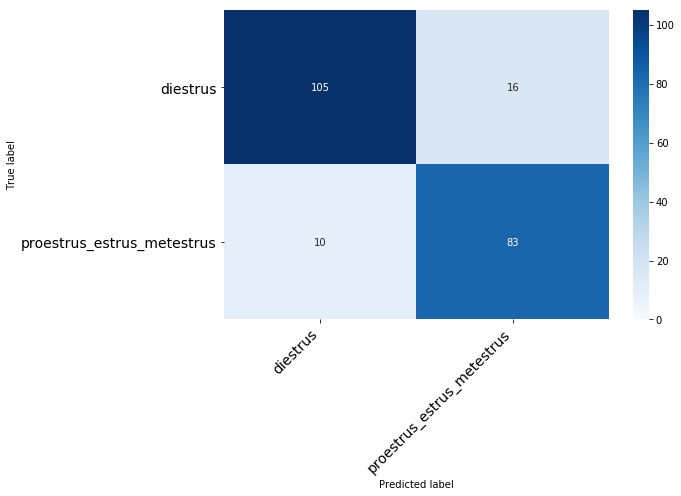

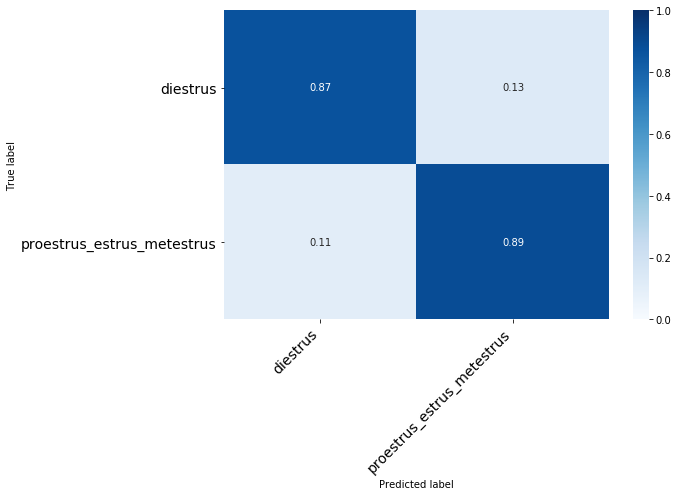

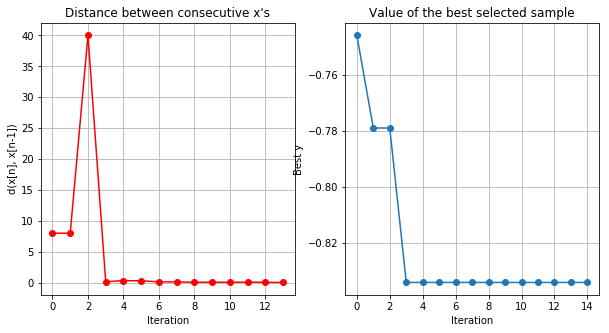

Best params: {'batch_size': 64.0, 'lr_decay': 0.11536812062702188, 'adam_lr': 0.05344037850255675, 'adam_beta1': 0.8723341253595566, 'adam_beta2': 0.958634089159281, 'adam_wtdecay': 0.9323112115197796}
Iteration BEST, {'batch_size': 64.0, 'lr_decay': 0.11536812062702188, 'adam_lr': 0.05344037850255675, 'adam_beta1': 0.8723341253595566, 'adam_beta2': 0.958634089159281, 'adam_wtdecay': 0.9323112115197796}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.7956; Associated train accuracy: 0.8968
Writing results to experiments/bayes_opt_2/4_class_tt/resnet101/Adam/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 74.98it/s]


14938

resnet101 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.26420661673596535, 'lr': 0.014696396914922954, 'momentum': 0.5478618374303446, 'weight_decay': 0.02162025971119763}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9194
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.14291766787021376, 'lr': 0.09801730452276676, 'momentum': 0.8321908074154334, 'weight_decay': 0.9577416834328525}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9214
Iteration 3, {'batch_size': 32.0, 'lr_decay': 0.29320949030186827, 'lr': 0.061342640231794705, 'momentum': 0.8488699719333364, 'weight_decay': 0.8357117867219434}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9175
Iteration 4, {'batch_size': 16.0, 'lr_decay': 0.2920018402053923, 'lr': 0.02644178638439233, 'momentum': 0.6529780180296222, 'weight_decay': 0.04848586604482308}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8611; Associated train accuracy: 0.9253
Iteration 5, {'batch_size': 24.0, 'lr_decay': 0.2244809551727221, 'lr': 0.009344942291000167, 'momentum': 0.5595143617198547, 'weight_decay': 0.7505081723015028}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.9106
Iteration 6, {'batch_size': 48.0, 'lr_decay': 0.07319590493192214, 'lr': 0.03980711449860944, 'momentum': 0.5427889426143848, 'weight_decay': 0.03625807695545687}


Training stopped early at 10 epochs.
Best validation accuracy: 0.8778; Associated train accuracy: 0.8919
Iteration 7, {'batch_size': 48.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.6085128269793681, 'weight_decay': 0.0}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.8929
Iteration 8, {'batch_size': 48.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.5496258137003839, 'weight_decay': 0.1484095724311906}


Training stopped early at 9 epochs.
Best validation accuracy: 0.7833; Associated train accuracy: 0.9106
Iteration 9, {'batch_size': 48.0, 'lr_decay': 0.27615116840535503, 'lr': 0.010049916788892372, 'momentum': 0.577143875825491, 'weight_decay': 0.0}


Training stopped early at 15 epochs.
Best validation accuracy: 0.9278; Associated train accuracy: 0.9430
Iteration 10, {'batch_size': 32.0, 'lr_decay': 0.2398838084068698, 'lr': 0.07828345980684433, 'momentum': 0.8869385859419409, 'weight_decay': 0.8129048363129595}


Training stopped early at 9 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.8694
Iteration 11, {'batch_size': 48.0, 'lr_decay': 0.2589526310525221, 'lr': 0.01628833135321496, 'momentum': 0.5880863508495433, 'weight_decay': 0.0}


Training stopped early at 15 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9519
Iteration 12, {'batch_size': 32.0, 'lr_decay': 0.3, 'lr': 0.03679503809037369, 'momentum': 0.7937074656669642, 'weight_decay': 0.8687591151173372}


Training stopped early at 19 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9528
Iteration 13, {'batch_size': 32.0, 'lr_decay': 0.3, 'lr': 0.07952536151141587, 'momentum': 0.8012833295774482, 'weight_decay': 0.902605353450262}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.9126
Iteration 14, {'batch_size': 48.0, 'lr_decay': 0.28872346200790205, 'lr': 0.025433902435595762, 'momentum': 0.5725692132065372, 'weight_decay': 0.0}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.8900
Iteration 15, {'batch_size': 48.0, 'lr_decay': 0.26490510927428046, 'lr': 0.001, 'momentum': 0.5809134624337272, 'weight_decay': 0.0}


Training stopped early at 23 epochs.
Best validation accuracy: 0.9222; Associated train accuracy: 0.9244
Best params: [4.80000000e+01 2.76151168e-01 1.00499168e-02 5.77143876e-01
 0.00000000e+00]


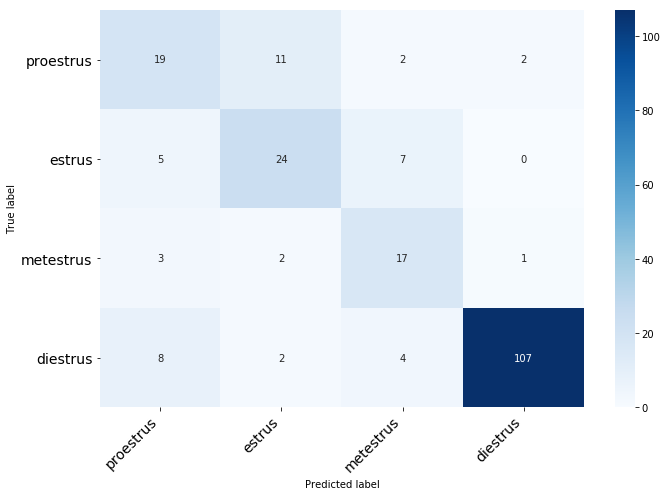

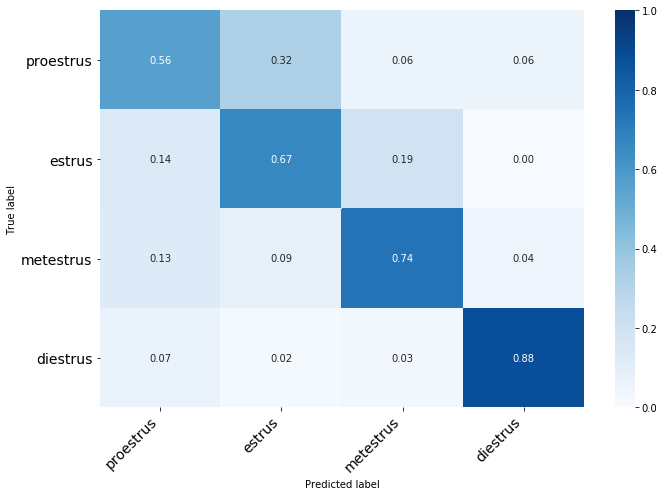

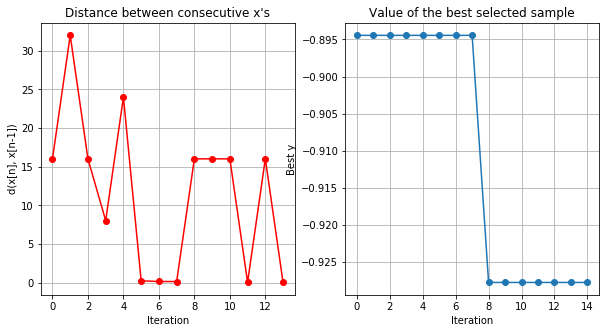

Best params: {'batch_size': 48.0, 'lr_decay': 0.27615116840535503, 'lr': 0.010049916788892372, 'momentum': 0.577143875825491, 'weight_decay': 0.0}
Iteration BEST, {'batch_size': 48.0, 'lr_decay': 0.27615116840535503, 'lr': 0.010049916788892372, 'momentum': 0.577143875825491, 'weight_decay': 0.0}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.9167; Associated train accuracy: 0.9352
Writing results to experiments/bayes_opt_2/die_vs_all_tt/resnet101/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 78.26it/s]


2285

resnet101 SGD data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.07701534341587588, 'lr': 0.05786543806200973, 'momentum': 0.9498064130366884, 'weight_decay': 0.9173381298304889}


Training stopped early at 8 epochs.
Best validation accuracy: 0.5635; Associated train accuracy: 0.5654
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.141666081758618, 'lr': 0.04654009802008573, 'momentum': 0.8267256018597532, 'weight_decay': 0.17707857751942235}


Training stopped early at 20 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8584
Iteration 3, {'batch_size': 24.0, 'lr_decay': 0.18151164884954402, 'lr': 0.058801249846455274, 'momentum': 0.8773838942776708, 'weight_decay': 0.674901111677248}


Training stopped early at 10 epochs.
Best validation accuracy: 0.5746; Associated train accuracy: 0.5615
Iteration 4, {'batch_size': 48.0, 'lr_decay': 0.22320943310655175, 'lr': 0.024680405884290966, 'momentum': 0.865346566904023, 'weight_decay': 0.8525269270654972}


Training stopped early at 14 epochs.
Best validation accuracy: 0.7514; Associated train accuracy: 0.8407
Iteration 5, {'batch_size': 24.0, 'lr_decay': 0.13495391896399378, 'lr': 0.07582362951975141, 'momentum': 0.7232577950523844, 'weight_decay': 0.2781050821202644}


Training stopped early at 14 epochs.
Best validation accuracy: 0.6354; Associated train accuracy: 0.6765
Iteration 6, {'batch_size': 64.0, 'lr_decay': 0.1532390056539865, 'lr': 0.044513139272812356, 'momentum': 0.8047025636372375, 'weight_decay': 0.044611083043559825}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8177; Associated train accuracy: 0.8466
Iteration 7, {'batch_size': 64.0, 'lr_decay': 0.3, 'lr': 0.01663342715379342, 'momentum': 0.501666579083731, 'weight_decay': 0.0}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.8859
Iteration 8, {'batch_size': 64.0, 'lr_decay': 0.03, 'lr': 0.1, 'momentum': 0.5, 'weight_decay': 0.0}


Training stopped early at 16 epochs.
Best validation accuracy: 0.6519; Associated train accuracy: 0.6332
Iteration 9, {'batch_size': 64.0, 'lr_decay': 0.3, 'lr': 0.001, 'momentum': 0.682434013736855, 'weight_decay': 0.025470698447243117}


Training stopped early at 18 epochs.
Best validation accuracy: 0.7348; Associated train accuracy: 0.7925
Iteration 10, {'batch_size': 64.0, 'lr_decay': 0.11150940786238095, 'lr': 0.05724231654685508, 'momentum': 0.9041092906909456, 'weight_decay': 0.054930932612069}


Training stopped early at 8 epochs.
Best validation accuracy: 0.5635; Associated train accuracy: 0.5241
Iteration 11, {'batch_size': 64.0, 'lr_decay': 0.15005994151925517, 'lr': 0.03792587422020584, 'momentum': 0.8059608039065811, 'weight_decay': 0.041161879224568064}


Training stopped early at 14 epochs.
Best validation accuracy: 0.6961; Associated train accuracy: 0.6765
Iteration 12, {'batch_size': 64.0, 'lr_decay': 0.25819303300042173, 'lr': 0.0025623416285121565, 'momentum': 0.6682792722381157, 'weight_decay': 0.050149645121135844}


Training stopped early at 20 epochs.
Best validation accuracy: 0.7901; Associated train accuracy: 0.8309
Iteration 13, {'batch_size': 64.0, 'lr_decay': 0.2946667416713419, 'lr': 0.005215134707024881, 'momentum': 0.603737773583415, 'weight_decay': 0.040157792979211716}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7680; Associated train accuracy: 0.8505
Iteration 14, {'batch_size': 64.0, 'lr_decay': 0.3, 'lr': 0.00644267326426082, 'momentum': 0.570943339116513, 'weight_decay': 0.0320356804340681}


Training stopped early at 19 epochs.
Best validation accuracy: 0.7624; Associated train accuracy: 0.8456
Iteration 15, {'batch_size': 64.0, 'lr_decay': 0.2983893975839199, 'lr': 0.01618853077946244, 'momentum': 0.5060576836218533, 'weight_decay': 0.0006688554615998}


Training stopped early at 16 epochs.
Best validation accuracy: 0.7790; Associated train accuracy: 0.8987
Best params: [6.40000000e+01 3.00000000e-01 1.66334272e-02 5.01666579e-01
 0.00000000e+00]


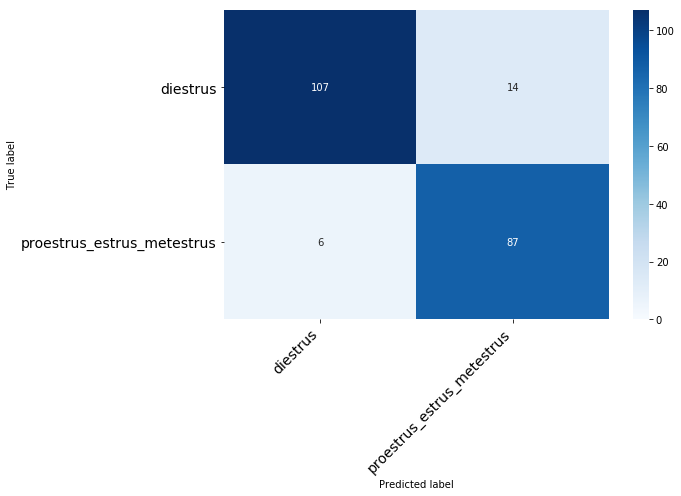

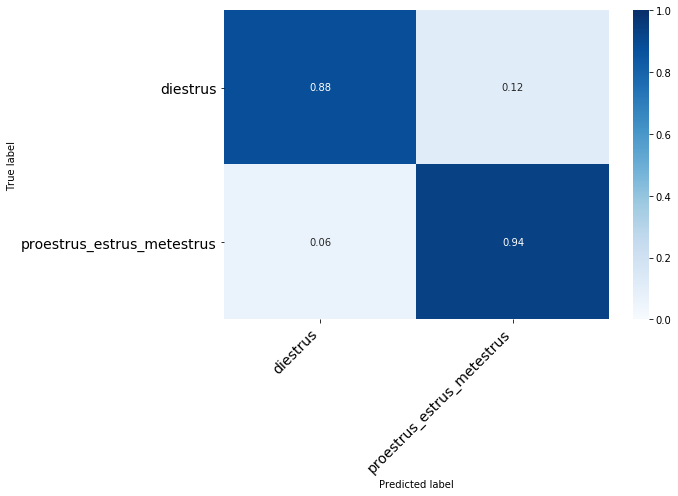

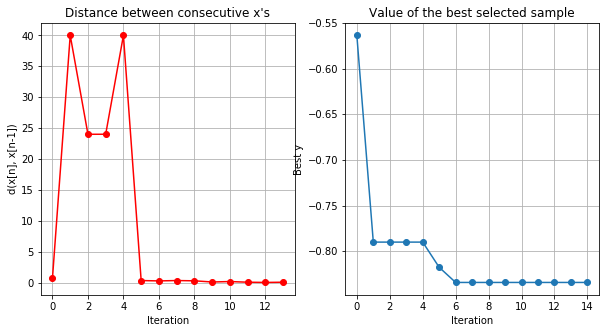

Best params: {'batch_size': 64.0, 'lr_decay': 0.3, 'lr': 0.01663342715379342, 'momentum': 0.501666579083731, 'weight_decay': 0.0}
Iteration BEST, {'batch_size': 64.0, 'lr_decay': 0.3, 'lr': 0.01663342715379342, 'momentum': 0.501666579083731, 'weight_decay': 0.0}


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Best validation accuracy: 0.7790; Associated train accuracy: 0.8997
Writing results to experiments/bayes_opt_2/4_class_tt/resnet101/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 75.54it/s]


13109

resnet152 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.2050849286322567, 'adam_lr': 0.09667129807828499, 'adam_beta1': 0.9643262203452514, 'adam_beta2': 0.9525531357139444, 'adam_wtdecay': 0.11428707297872209}


Training stopped early at 12 epochs.
Best validation accuracy: 0.5778; Associated train accuracy: 0.5648
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.15081022477364286, 'adam_lr': 0.0046924124736496126, 'adam_beta1': 0.8116589989497687, 'adam_beta2': 0.9981793819363234, 'adam_wtdecay': 0.24163002304937597}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8944; Associated train accuracy: 0.9273
Iteration 3, {'batch_size': 16.0, 'lr_decay': 0.24428788694236794, 'adam_lr': 0.0741353689703753, 'adam_beta1': 0.9437189667554601, 'adam_beta2': 0.9501117610967715, 'adam_wtdecay': 0.5275638269117237}


Training stopped early at 19 epochs.
Best validation accuracy: 0.9111; Associated train accuracy: 0.9047
Iteration 4, {'batch_size': 64.0, 'lr_decay': 0.15447647913278162, 'adam_lr': 0.060094295440392145, 'adam_beta1': 0.9016693543482309, 'adam_beta2': 0.99263172610237, 'adam_wtdecay': 0.14726091291660015}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

5640

resnet152 Adam data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.041030359133663756, 'adam_lr': 0.03414510852167713, 'adam_beta1': 0.9468308414964981, 'adam_beta2': 0.9665855363271905, 'adam_wtdecay': 0.006208124831906803}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

478

resnet152 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.1036886206240781, 'lr': 0.09327473758623973, 'momentum': 0.6967522033912475, 'weight_decay': 0.6240375021612556}


Training stopped early at 16 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9430
Iteration 2, {'batch_size': 32.0, 'lr_decay': 0.2798573022080868, 'lr': 0.07644155285674867, 'momentum': 0.8633065610563169, 'weight_decay': 0.7382882050343836}


Training stopped early at 24 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9185
Iteration 3, {'batch_size': 24.0, 'lr_decay': 0.1601955531523594, 'lr': 0.07150360568569569, 'momentum': 0.9570303316538478, 'weight_decay': 0.682266629115453}


Training stopped early at 21 epochs.
Best validation accuracy: 0.6722; Associated train accuracy: 0.6542
Iteration 4, {'batch_size': 16.0, 'lr_decay': 0.27210421387941547, 'lr': 0.014920225228084172, 'momentum': 0.9185556028558602, 'weight_decay': 0.9124677954969609}


Training stopped early at 10 epochs.
Best validation accuracy: 0.9167; Associated train accuracy: 0.9244
Iteration 5, {'batch_size': 48.0, 'lr_decay': 0.18624943249329498, 'lr': 0.08155279454516917, 'momentum': 0.5638869874326908, 'weight_decay': 0.3150321099242811}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8444; Associated train accuracy: 0.8890
Iteration 6, {'batch_size': 16.0, 'lr_decay': 0.09812826752930764, 'lr': 0.006614943526135572, 'momentum': 0.8234160818978428, 'weight_decay': 0.792762469690326}


Training stopped early at 13 epochs.
Best validation accuracy: 0.9056; Associated train accuracy: 0.9214
Iteration 7, {'batch_size': 32.0, 'lr_decay': 0.3, 'lr': 0.07813216882227002, 'momentum': 0.819170064403347, 'weight_decay': 0.748254554508649}


Training stopped early at 18 epochs.
Best validation accuracy: 0.8889; Associated train accuracy: 0.9194
Iteration 8, {'batch_size': 16.0, 'lr_decay': 0.3, 'lr': 0.1, 'momentum': 0.99, 'weight_decay': 0.0}


Training stopped early at 12 epochs.
Best validation accuracy: 0.6056; Associated train accuracy: 0.6002
Iteration 9, {'batch_size': 32.0, 'lr_decay': 0.03, 'lr': 0.0497183638557513, 'momentum': 0.99, 'weight_decay': 0.5807523697528014}


Training stopped early at 9 epochs.
Best validation accuracy: 0.5667; Associated train accuracy: 0.5796
Iteration 10, {'batch_size': 16.0, 'lr_decay': 0.15411777627840062, 'lr': 0.001, 'momentum': 0.8476248759919961, 'weight_decay': 0.9379891309865303}


Training stopped early at 15 epochs.
Best validation accuracy: 0.8500; Associated train accuracy: 0.8762
Iteration 11, {'batch_size': 16.0, 'lr_decay': 0.25098759324689324, 'lr': 0.024385833707769488, 'momentum': 0.9151837672261163, 'weight_decay': 0.7617941034311531}


Training stopped early at 25 epochs.
Best validation accuracy: 0.8722; Associated train accuracy: 0.9214
Iteration 12, {'batch_size': 32.0, 'lr_decay': 0.3, 'lr': 0.09747252054032525, 'momentum': 0.9483234073655011, 'weight_decay': 0.862262056797204}


Training stopped early at 21 epochs.
Best validation accuracy: 0.8556; Associated train accuracy: 0.7633
Iteration 13, {'batch_size': 16.0, 'lr_decay': 0.03, 'lr': 0.001, 'momentum': 0.7221238564261442, 'weight_decay': 0.6626993242699548}


Training stopped early at 12 epochs.
Best validation accuracy: 0.8333; Associated train accuracy: 0.8949
Iteration 14, {'batch_size': 16.0, 'lr_decay': 0.3, 'lr': 0.1, 'momentum': 0.99, 'weight_decay': 0.9555051204700301}


Training stopped early at 10 epochs.
Best validation accuracy: 0.6056; Associated train accuracy: 0.5079
Iteration 15, {'batch_size': 16.0, 'lr_decay': 0.25093526069540595, 'lr': 0.001, 'momentum': 0.8831712779153271, 'weight_decay': 0.8708523273872161}


Training stopped early at 19 epochs.
Best validation accuracy: 0.8833; Associated train accuracy: 0.8988
Best params: [1.60000000e+01 2.72104214e-01 1.49202252e-02 9.18555603e-01
 9.12467795e-01]


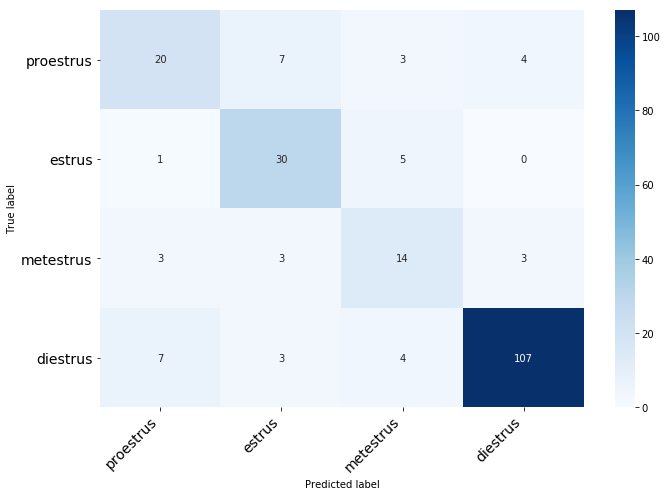

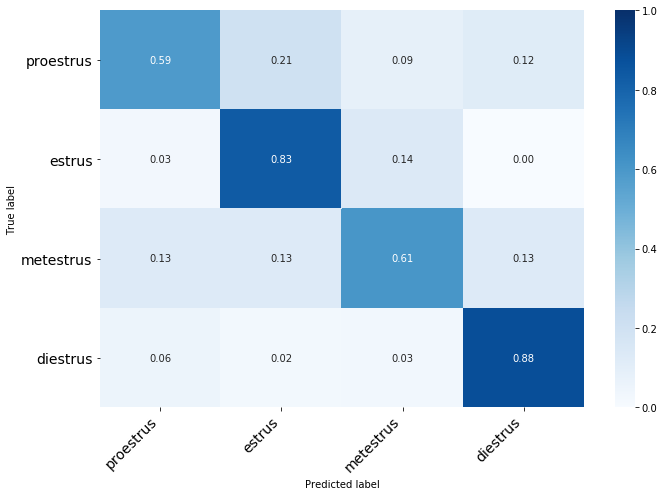

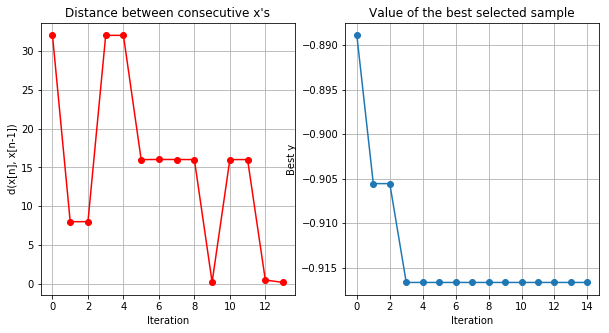

Best params: {'batch_size': 16.0, 'lr_decay': 0.27210421387941547, 'lr': 0.014920225228084172, 'momentum': 0.9185556028558602, 'weight_decay': 0.9124677954969609}
Iteration BEST, {'batch_size': 16.0, 'lr_decay': 0.27210421387941547, 'lr': 0.014920225228084172, 'momentum': 0.9185556028558602, 'weight_decay': 0.9124677954969609}


Best validation accuracy: 0.9222; Associated train accuracy: 0.9430


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Writing results to experiments/bayes_opt_2/die_vs_all_tt/resnet152/SGD/BEST/test_predictions.csv


Predict: 100%|██████████| 214/214 [00:02<00:00, 76.79it/s]


16295

resnet152 SGD data/4_class_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.07366550516307663, 'lr': 0.07083510082437752, 'momentum': 0.7608661501647682, 'weight_decay': 0.26520952279840815}


Training stopped early at 13 epochs.
Best validation accuracy: 0.6354; Associated train accuracy: 0.6155
Iteration 2, {'batch_size': 64.0, 'lr_decay': 0.04531845818430349, 'lr': 0.046281948356080994, 'momentum': 0.5275197754901336, 'weight_decay': 0.6767729074820945}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

1413

senet154 Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.2505414782887465, 'adam_lr': 0.07252734595346182, 'adam_beta1': 0.9465512221498354, 'adam_beta2': 0.9899289348099096, 'adam_wtdecay': 0.8519020598838222}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

478

senet154 Adam data/4_class_tt
Iteration 1, {'batch_size': 48.0, 'lr_decay': 0.11214941672166981, 'adam_lr': 0.001583928244193762, 'adam_beta1': 0.9867679618638008, 'adam_beta2': 0.9554944767182191, 'adam_wtdecay': 0.6738187085755236}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

684

senet154 SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.05981066019792887, 'lr': 0.053048921911469045, 'momentum': 0.7177131872072384, 'weight_decay': 0.6412136618982425}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

684

senet154 SGD data/4_class_tt
Iteration 1, {'batch_size': 64.0, 'lr_decay': 0.22975396747060317, 'lr': 0.05469270502728006, 'momentum': 0.5200339061687362, 'weight_decay': 0.733498557235269}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

684

pnasnet5large Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 4.0, 'lr_decay': 0.23649520422278866, 'adam_lr': 0.03128267370148717, 'adam_beta1': 0.8087664579778977, 'adam_beta2': 0.9542533837481998, 'adam_wtdecay': 0.3362545370208335}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

684

pnasnet5large Adam data/4_class_tt
Iteration 1, {'batch_size': 12.0, 'lr_decay': 0.09285928108483617, 'adam_lr': 0.049485116482999005, 'adam_beta1': 0.9329013763572391, 'adam_beta2': 0.9956567129014872, 'adam_wtdecay': 0.8250971287597605}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

788

pnasnet5large SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 4.0, 'lr_decay': 0.21741155640650273, 'lr': 0.020983695351383152, 'momentum': 0.6302426222534914, 'weight_decay': 0.5257485908114973}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

788

pnasnet5large SGD data/4_class_tt
Iteration 1, {'batch_size': 1.0, 'lr_decay': 0.2251726760543449, 'lr': 0.013937645938452842, 'momentum': 0.6271208505929979, 'weight_decay': 0.1172652455942742}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7403; Associated train accuracy: 0.7424
Iteration 2, {'batch_size': 12.0, 'lr_decay': 0.18697557922053296, 'lr': 0.009379811319068652, 'momentum': 0.5464213699461888, 'weight_decay': 0.4166877348386857}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

3131

polynet Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 12.0, 'lr_decay': 0.14680238979667168, 'adam_lr': 0.08966439009646113, 'adam_beta1': 0.9645498397937595, 'adam_beta2': 0.9989113226423483, 'adam_wtdecay': 0.03182752610975026}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

788

polynet Adam data/4_class_tt
Iteration 1, {'batch_size': 8.0, 'lr_decay': 0.13630569917493046, 'adam_lr': 0.008318945406125905, 'adam_beta1': 0.882576941318083, 'adam_beta2': 0.9689821113197168, 'adam_wtdecay': 0.47190108554762544}


Training stopped early at 25 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.8230
Iteration 2, {'batch_size': 8.0, 'lr_decay': 0.23417418056495962, 'adam_lr': 0.005788407143615663, 'adam_beta1': 0.8027400254746486, 'adam_beta2': 0.9898933341192642, 'adam_wtdecay': 0.02807055820935722}


Training stopped early at 23 epochs.
Best validation accuracy: 0.7514; Associated train accuracy: 0.7060
Iteration 3, {'batch_size': 4.0, 'lr_decay': 0.25416573567485534, 'adam_lr': 0.08188292987129353, 'adam_beta1': 0.8933311264768765, 'adam_beta2': 0.9880227879609521, 'adam_wtdecay': 0.26547821581801156}


Training stopped early at 8 epochs.
Best validation accuracy: 0.5746; Associated train accuracy: 0.5133
Iteration 4, {'batch_size': 12.0, 'lr_decay': 0.27508944473460845, 'adam_lr': 0.08763911493090283, 'adam_beta1': 0.9376235265853405, 'adam_beta2': 0.9648955598993657, 'adam_wtdecay': 0.5162400813671496}


Training stopped early at 16 epochs.
Best validation accuracy: 0.5967; Associated train accuracy: 0.5674
Iteration 5, {'batch_size': 12.0, 'lr_decay': 0.11508765251212791, 'adam_lr': 0.08645732481528062, 'adam_beta1': 0.9135324002347546, 'adam_beta2': 0.9769693016016165, 'adam_wtdecay': 0.13914363947472208}


Training stopped early at 9 epochs.
Best validation accuracy: 0.5746; Associated train accuracy: 0.5526
Iteration 6, {'batch_size': 8.0, 'lr_decay': 0.04161434856027843, 'adam_lr': 0.010498083414665916, 'adam_beta1': 0.9597193190322718, 'adam_beta2': 0.95, 'adam_wtdecay': 0.9022934138458159}


Training stopped early at 13 epochs.
Best validation accuracy: 0.7735; Associated train accuracy: 0.7719
Iteration 7, {'batch_size': 8.0, 'lr_decay': 0.3, 'adam_lr': 0.1, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.6309772959669716}


Training stopped early at 7 epochs.
Best validation accuracy: 0.5635; Associated train accuracy: 0.5113
Iteration 8, {'batch_size': 8.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.9415481618106358, 'adam_beta2': 0.9798459390208758, 'adam_wtdecay': 0.4083691013013246}


Training stopped early at 13 epochs.
Best validation accuracy: 0.8177; Associated train accuracy: 0.8289
Iteration 9, {'batch_size': 8.0, 'lr_decay': 0.11913056197005192, 'adam_lr': 0.001, 'adam_beta1': 0.8854121220907534, 'adam_beta2': 0.9743333335528191, 'adam_wtdecay': 0.38934710127894734}


Training stopped early at 12 epochs.
Best validation accuracy: 0.7956; Associated train accuracy: 0.8378
Iteration 10, {'batch_size': 8.0, 'lr_decay': 0.06669541052824687, 'adam_lr': 0.001, 'adam_beta1': 0.9255041484036997, 'adam_beta2': 0.9713779629791378, 'adam_wtdecay': 0.50949830693409}


Training stopped early at 23 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.8437
Iteration 11, {'batch_size': 8.0, 'lr_decay': 0.13649131616328938, 'adam_lr': 0.001, 'adam_beta1': 0.99, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.47646972884975997}


Training stopped early at 17 epochs.
Best validation accuracy: 0.7017; Associated train accuracy: 0.7915
Iteration 12, {'batch_size': 8.0, 'lr_decay': 0.055739781525853384, 'adam_lr': 0.002283631352142743, 'adam_beta1': 0.8560862898540379, 'adam_beta2': 0.9522575436146054, 'adam_wtdecay': 0.4795386240036642}


Training stopped early at 11 epochs.
Best validation accuracy: 0.8343; Associated train accuracy: 0.8073
Iteration 13, {'batch_size': 8.0, 'lr_decay': 0.05602008478740641, 'adam_lr': 0.05932236213927714, 'adam_beta1': 0.8818827109894544, 'adam_beta2': 0.9999, 'adam_wtdecay': 0.48001284047168613}


Training stopped early at 18 epochs.
Best validation accuracy: 0.7735; Associated train accuracy: 0.7561
Iteration 14, {'batch_size': 8.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.9404662544365966, 'adam_beta2': 0.95, 'adam_wtdecay': 0.22866123816718018}


Training stopped early at 8 epochs.
Best validation accuracy: 0.8066; Associated train accuracy: 0.7394
Iteration 15, {'batch_size': 8.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.3991796201636114}


Training stopped early at 23 epochs.
Best validation accuracy: 0.8508; Associated train accuracy: 0.8535
Best params: [8.0000000e+00 3.0000000e-02 1.0000000e-03 8.0000000e-01 9.5000000e-01
 3.9917962e-01]


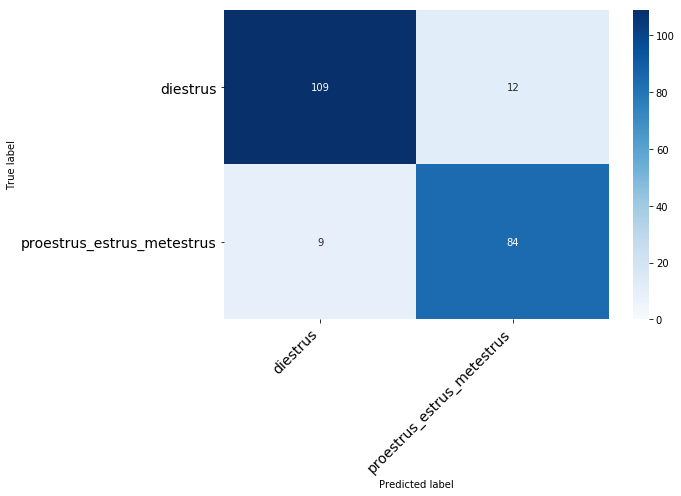

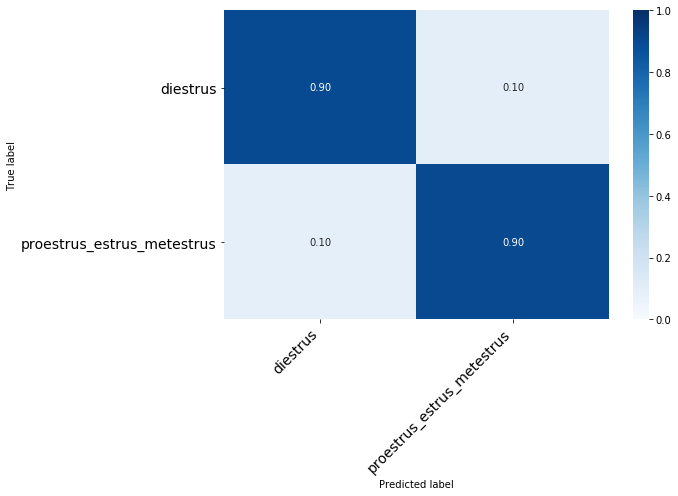

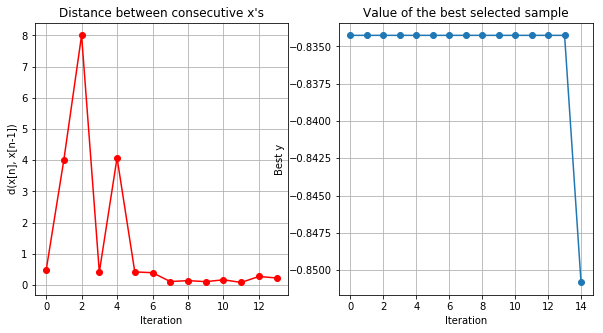

Best params: {'batch_size': 8.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.3991796201636114}
Iteration BEST, {'batch_size': 8.0, 'lr_decay': 0.03, 'adam_lr': 0.001, 'adam_beta1': 0.8, 'adam_beta2': 0.95, 'adam_wtdecay': 0.3991796201636114}


Best validation accuracy: 0.8177; Associated train accuracy: 0.8102


 /home/alwood/Development/Estrous-AI/predict.py:114: DeprecationWarning:Call to deprecated function (or staticmethod) get_datasets_and_loaders.
Predict:   0%|          | 0/214 [00:00<?, ?it/s]

Writing results to experiments/bayes_opt_2/4_class_tt/polynet/Adam/BEST/test_predictions.csv


Skipping because Given input size: (2048x5x5). Calculated output size: (2048x-3x-3). Output size is too small at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THCUNN/generic/SpatialAveragePooling.cu:63


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 26, in <module>
    generate_test_metrics(best_trainable)
  File "<ipython-input-11-cd55f18bf2e7>", line 62, in generate_test_metrics
    model=best_trainable.model
  File "/home/alwood/Development/Estrous-AI/predict.py", line 72, in create_predictions
    raw_outputs = model(inputs)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/pretrainedmodels/models/polynet.py", line 456, in forward
    x = self.logits(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/pretrainedmodels/models/polynet.py", line 448, in logits
    x = self.avg_pool(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/torch/nn/modules/module.py", line 477, in __call__
    result = self.forward(*input, **kwargs)
  File "

1446

polynet SGD data/die_vs_all_tt
Iteration 1, {'batch_size': 4.0, 'lr_decay': 0.04724496351686629, 'lr': 0.09593266689419255, 'momentum': 0.659872785831881, 'weight_decay': 0.7143821297053699}


Training stopped early at 15 epochs.
Best validation accuracy: 0.7278; Associated train accuracy: 0.6758
Iteration 2, {'batch_size': 4.0, 'lr_decay': 0.13274145660234218, 'lr': 0.08339280412367286, 'momentum': 0.8001751718103489, 'weight_decay': 0.4337515255082006}


Training stopped early at 18 epochs.
Best validation accuracy: 0.6944; Associated train accuracy: 0.6012
Iteration 3, {'batch_size': 8.0, 'lr_decay': 0.17459104342339204, 'lr': 0.07635440486820812, 'momentum': 0.5402935301342803, 'weight_decay': 0.3720813197038635}


Training stopped early at 12 epochs.
Best validation accuracy: 0.6111; Associated train accuracy: 0.6139
Iteration 4, {'batch_size': 1.0, 'lr_decay': 0.1410653157279878, 'lr': 0.007619016114183102, 'momentum': 0.5352462409940308, 'weight_decay': 0.5510156956006186}


Training stopped early at 7 epochs.
Best validation accuracy: 0.6000; Associated train accuracy: 0.6631
Iteration 5, {'batch_size': 12.0, 'lr_decay': 0.11527738697975277, 'lr': 0.09357915295026971, 'momentum': 0.6438993695110504, 'weight_decay': 0.26575712630463144}


Skipping because CUDA error: out of memory


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

8982

polynet SGD data/4_class_tt
Iteration 1, {'batch_size': 12.0, 'lr_decay': 0.07700681857885991, 'lr': 0.09074541065086551, 'momentum': 0.7875385307795522, 'weight_decay': 0.767282801416619}
Skipping because cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1532579805626/work/aten/src/THC/THCTensorCopy.cu:206


Traceback (most recent call last):
  File "<ipython-input-12-64ea5eee590f>", line 17, in <module>
    optimized = perform_bayesian_optimization()
  File "<ipython-input-11-cd55f18bf2e7>", line 31, in perform_bayesian_optimization
    maximize=True
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 118, in __init__
    self._init_design_chooser()
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/methods/bayesian_optimization.py", line 193, in _init_design_chooser
    self.Y, _ = self.objective.evaluate(self.X)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 50, in evaluate
    f_evals, cost_evals = self._eval_func(x)
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-packages/GPyOpt/core/task/objective.py", line 74, in _eval_func
    rlt = self.func(np.atleast_2d(x[i]))
  File "/home/alwood/anaconda3/envs/eai/lib/python3.6/site-package

4490

nasnetalarge Adam data/die_vs_all_tt
Iteration 1, {'batch_size': 1.0, 'lr_decay': 0.2693920752358231, 'adam_lr': 0.04167731494817632, 'adam_beta1': 0.8108890999156367, 'adam_beta2': 0.9643842620823826, 'adam_wtdecay': 0.9390664011144452}


Training stopped early at 10 epochs.
Best validation accuracy: 0.6556; Associated train accuracy: 0.7780
Iteration 2, {'batch_size': 1.0, 'lr_decay': 0.11652949864791685, 'adam_lr': 0.04245593649413743, 'adam_beta1': 0.922774383741293, 'adam_beta2': 0.9876648726575055, 'adam_wtdecay': 0.8546072845072403}


Training stopped early at 8 epochs.
Best validation accuracy: 0.5611; Associated train accuracy: 0.8153
Iteration 3, {'batch_size': 1.0, 'lr_decay': 0.04374063185488516, 'adam_lr': 0.06465403370619412, 'adam_beta1': 0.8848564371098826, 'adam_beta2': 0.9695707860407521, 'adam_wtdecay': 0.6452317941347372}


Epoch 7, Train, best val=0.5667 , remaining tries: 1:  97%|█████████▋| 987/1018 [04:21<00:08,  3.79images/s] 

In [ ]:
import gc # for manual garbage collection, reduce memory consumption

for chosen_model in MODELS:  # iterate over all models
    for chosen_optimizer in OPTIMIZERS: # iterate over all optimizers

        # iterate over both binary and quaternary datasets
        for data_dir in (
            os.path.join('data', 'die_vs_all_tt'), 
            os.path.join('data', '4_class_tt')
        ):
            print(utils.get_model_name(chosen_model), chosen_optimizer.__name__, data_dir)
            reset_globals(data_dir)  # reset some globals used for iteration tracking

            commit_message = f'Results for {data_dir} {utils.get_model_name(chosen_model)} {chosen_optimizer.__name__}.'
            try:
                # define and optimize the problem
                optimized = perform_bayesian_optimization()
                # plot the results
                plot_bo_results(optimized)
                # get and save the best trainable
                best_params = optimized.x_opt.flatten()
                print('Best params:', (params_to_meta_dict(best_params)))
                best_trainable = train(best_params, is_best=True)
                best_trainable.save(extra_meta=params_to_meta_dict(best_params))
                # evalute on the test set using the best model
                generate_test_metrics(best_trainable)
                commit_message += f' Best val: {best_trainable.best_val_accuracy:.4f}; Train: {best_trainable.associated_train_accuracy:.4f}'
                
            # if something bad happens, skip it so we can let the others run
            except Exception as e:
                print('Skipping because', e)
                _ = subprocess.check_call(["spd-say", "Uh-oh, something bad happened. "])
                _ = subprocess.check_call(["spd-say", f'{utils.get_model_name(chosen_model)}. {str(e).split()[:4]}.'])
                    
                import traceback  # DEBUG
                traceback.print_exc()
                commit_message += f' EXCEPTION {e}.'
    
            gc.collect()  # reduce memory usage

            # commit & push
            if PUSH_TO_GIT:
                push_to_git(commit_message)

# Final Commit and Push

In [ ]:
if PUSH_TO_GIT:
    import time
    time.sleep(120) # wait for two minutes to let everything render
    _ = subprocess.check_call(["spd-say", "Your code has finished running"])
    push_to_git("BO Final Commit")
    
print("Done")

In [ ]:
_ = subprocess.check_call(["./bo-2-rerun.sh"])